# Executive Summary

The goal of this project is to provide recommendations for your NFL fantasy league. My initial idea was to scrap data from a website that gives each NFL offensive player's statistics from 2014 and use that data to come up with best predictive model to pick the best players. The success criteria of the model is to have a better R^2 value than the expert's projections. The expert's projections were scraped from fantasypros.com. The R^2 value from the experts compared to the actual results was 0.6. Therefore, I needed to come up with a model that gives better R^2 value than 0.6. The models that I tried was linear regression, Lasso linear regression, Decision Tree Regressor with optimized depth, and Random Forest Regressor. However, the R^2 value for the QB position and RB position was significantly weaker than the expert's projection. The shortcomings from the model comes from less lack variety in the features. There are more factors that will affect the player's performance in the next season. Therefore, it is safe to conclude that the previous year's performances cannot predict better results on player's performance on next year's season. Next steps that I took was to take the projections made by the experts and cluster them into ranks or tiers. The idea was to group players with similar qualities into ranks or tiers. Since the draft order is sequential for league players, it is easier to distinguish whether one player predicted to perform similarly to other players. I used three clustering algorithms: DBSCAN, K-Means, and Gaussian Mixture Model. DBSCAN did not perform very well since relative distance was not optimized. K-Means clustering did not work well since the type of data that I had was not hyper-spherical. Gaussian Mixture Model successfully grouped these players into tiers of similar qualities. In order to improve my original predictive models, I need to have different features such as team ranking, injuries, and research other unknown features that might be impactful. More research and analysis on how other experts predict the next year's performances in order to select the best features for the model. For the clustering algorithms, having more features would cluster them into groups more evenly. Splitting the clustering by different positions would provide a nice insight on how you should draft players as well.

# Getting started
I need to create a model that will be more accurate than compilation of experts' projections. In order to do that, I need to get the data for the 2015 season along with 2015's preseason projections made by the experts. My goal would be to use the stats from previous season to beat the accuracy score of the experts' projections. My models will be segmented by each position groups and perform different regression models such as linear, Lasso, random forest, and few other models for each position groups.

The current risk I foresee is that some players will get injured, suspended, or retire. The likelihood for injury can be accounted from previous seasons such as how many times they got injured in past seasons. Also, I don't have any data on any rookie players. The age needs to be considered. Since players are humans, they cannot perform exactly the same every season.


In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#function that will group rows together
def group(iterator, count):
    itr = iter(iterator)
    while True:
        yield tuple([itr.next() for i in range(count)])


# Data Mining for 2015 preseason projections


In [2]:
#scraping the 2015 QB projection page from fantasypros
soupQB = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/projections/qb.php?year=2015&week=draft').text,'lxml')

#find the body of the table
data_QB = soupQB('table')[0].findAll('tbody')[0].text.strip().split()

#list of team initials for the entire NFL teams
teamList = ['NE','NYJ','MIA','BUF','PIT','BAL','CLE','CIN','HOU','IND',
            'JAC','TEN','DEN','KC','SD','OAK','DAL','WAS','NYG','PHI',
            'MIN','GB','DET','CHI','NO','TB','ATL','CAR','SF','SEA','ARI','STL','LA']

#get rid of the teams
data_QB_noTeam = [i for i in data_QB if i not in teamList]

#recreate the table from the website into pandas dataframe
dfQB = pd.DataFrame(list(group(data_QB_noTeam, 12)))

#join first name and last name together into the same column
dfQB[0] = dfQB[[0,1]].apply(lambda x: ' '.join(x),axis=1)

#drop the last name column
del dfQB[1]

#insert a column for the type of position. For this table, QB.

dfQB.insert(1, 'Position', 'QB')

#column name for this table
column_QB = ['Player','Position','Pass_Attempt','Pass_Completion','Pass_Yards','Pass_Touchdowns','Interceptions',
                 'Rush_Attempt','Rush_Yards','Rush_Touchdowns','Fumbles_Lost','Fantasy_Points']

#set the columns
dfQB.columns = column_QB

dfQB.describe()

,Player,Position,Pass_Attempt,Pass_Completion,Pass_Yards,Pass_Touchdowns,Interceptions,Rush_Attempt,Rush_Yards,Rush_Touchdowns,Fumbles_Lost,Fantasy_Points
count,76,76,76,76,76,76,76,76,76,76,76,76
unique,76,1,67,65,67,47,45,56,60,22,28,66
top,Kellen Clemens,QB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,1,76,10,11,10,14,13,13,13,36,14,10


In [3]:
#scraping the 2015 RB projection page from fantasypros
soupRB = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/projections/rb.php?year=2015&week=draft').text,'lxml')

data_RB = soupRB('table')[0].findAll('tbody')[0].text.strip().split()

data_RB_noTeam = [i for i in data_RB if i not in teamList]

dfRB = pd.DataFrame(list(group(data_RB_noTeam, 10)))

dfRB[0] = dfRB[[0,1]].apply(lambda x: ' '.join(x),axis=1)

del dfRB[1]

dfRB.insert(1, 'Position', 'RB')

column_RB = ['Player','Position','Rush_Attempt','Rush_Yards','Rush_Touchdowns','Rec','Receive_Yards','Receive_Touchdowns',
             'Fumbles_Lost','Fantasy_Points']

dfRB.columns = column_RB

dfRB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 10 columns):
Player                152 non-null object
Position              152 non-null object
Rush_Attempt          152 non-null object
Rush_Yards            152 non-null object
Rush_Touchdowns       152 non-null object
Rec                   152 non-null object
Receive_Yards         152 non-null object
Receive_Touchdowns    152 non-null object
Fumbles_Lost          152 non-null object
Fantasy_Points        152 non-null object
dtypes: object(10)
memory usage: 11.9+ KB


In [4]:
#scraping the RB page
soupWR = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/projections/wr.php?year=2015&week=draft').text)

data_WR = soupWR('table')[0].findAll('tbody')[0].text.strip().split()

data_WR_noTeam = [i for i in data_WR if i not in teamList and i != 'Jr.']

dfWR = pd.DataFrame(list(group(data_WR_noTeam, 10)))

dfWR[0] = dfWR[[0,1]].apply(lambda x: ' '.join(x),axis=1)

del dfWR[1]

dfWR.insert(1, 'Position', 'WR')

column_WR = ['Player','Position','Rush_Attempt','Rush_Yards','Rush_Touchdowns','Rec','Receive_Yards','Receive_Touchdowns',
             'Fumbles_Lost','Fantasy_Points']

dfWR.columns = column_WR

dfWR.head()

/Users/SangYeob/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


,Player,Position,Rush_Attempt,Rush_Yards,Rush_Touchdowns,Rec,Receive_Yards,Receive_Touchdowns,Fumbles_Lost,Fantasy_Points
0,Antonio Brown,WR,4.8,23.2,0.0,116.8,"1,538.5",10.0,1.8,212.6
1,Demaryius Thomas,WR,0.0,0.0,0.0,102.4,"1,414.5",11.6,0.3,210.2
2,Dez Bryant,WR,0.1,0.5,0.0,89.8,"1,330.2",11.9,0.4,203.4
3,Odell Beckham,WR,4.1,28.1,0.0,101.8,"1,394.0",10.5,1.6,202.3
4,Julio Jones,WR,1.7,9.2,0.0,102.7,"1,430.1",8.4,0.9,192.4


In [5]:
#scraping the TE page
soupTE = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/projections/te.php?year=2015&week=draft').text)

data_TE = soupTE('table')[0].findAll('tbody')[0].text.strip().split()

data_TE_noTeam = [i for i in data_TE if i not in teamList]

dfTE = pd.DataFrame(list(group(data_TE_noTeam, 7)))

dfTE[0] = dfTE[[0,1]].apply(lambda x: ' '.join(x),axis=1)

del dfTE[1]

dfTE.insert(1, 'Position', 'TE')

column_TE = ['Player','Position','Rec','Receive_Yards','Receive_Touchdowns','Fumbles_Lost','Fantasy_Points']

dfTE.columns = column_TE

dfTE.head()

,Player,Position,Rec,Receive_Yards,Receive_Touchdowns,Fumbles_Lost,Fantasy_Points
0,Rob Gronkowski,TE,83.0,"1,101.3",10.2,0.2,171.2
1,Jimmy Graham,TE,70.4,860.7,8.8,1.4,136.1
2,Greg Olsen,TE,78.0,926.5,5.6,0.4,125.4
3,Travis Kelce,TE,72.4,851.9,6.2,2.4,117.3
4,Martellus Bennett,TE,78.8,827.9,5.3,0.3,114.2


In [6]:
#scraping the Kickers page
soupK = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/projections/k.php?year=2015&week=draft').text)

data_K = soupK('table')[0].findAll('tbody')[0].text.strip().split()

data_K_noTeam = [i for i in data_K if i not in teamList]

dfK = pd.DataFrame(list(group(data_K_noTeam, 6)))

dfK[0] = dfK[[0,1]].apply(lambda x: ' '.join(x),axis=1)

del dfK[1]

dfK.insert(1, 'Position', 'K')

column_K = ['Player','Position','FGM','FGA','Fumbles_Lost','Fantasy_Points']

dfK.columns = column_K

dfK.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
Player            32 non-null object
Position          32 non-null object
FGM               32 non-null object
FGA               32 non-null object
Fumbles_Lost      32 non-null object
Fantasy_Points    32 non-null object
dtypes: object(6)
memory usage: 1.6+ KB



| Columns | Descriptions| Type
|------|------|------|
|Player| First and Last name of players| Categorical|
|Position| Position of players| Categorical|
|Pass_Attempt| number of attempts by passing| Discrete/integer|
|Pass_Completion| number of completions by passing| Discrete/integer|
|Pass_Yards| number of yards by passing|Discrete/integer|
|Pass_Touchdowns| number of touchdowns by passing |Discrete/integer|
|Interceptions| number of interceptions|Discrete/integer|
|Rush_Attempt| number of rush attempts|Discrete/integer|
|Rush_Yards| number of yards by rushing|Discrete/integer|
|Rush_Touchdowns| number of touchdowns by rushing|Discrete/integer|
|Fumbles_Lost| number of fumbles|Discrete/integer|
|Fantasy_Points| total fantasy points|Continuous/float|
|Rec| number of receptions|Discrete/integer|
|Receive_Yards| number of yards by reception|Discrete/integer|
|Receive_Touchdowns| number of touchdowns by reception|Discrete/integer|
|FGM| Field Goals Made|Discrete/integer|
|FGA| Field Goal Attempts|Discrete/integer|


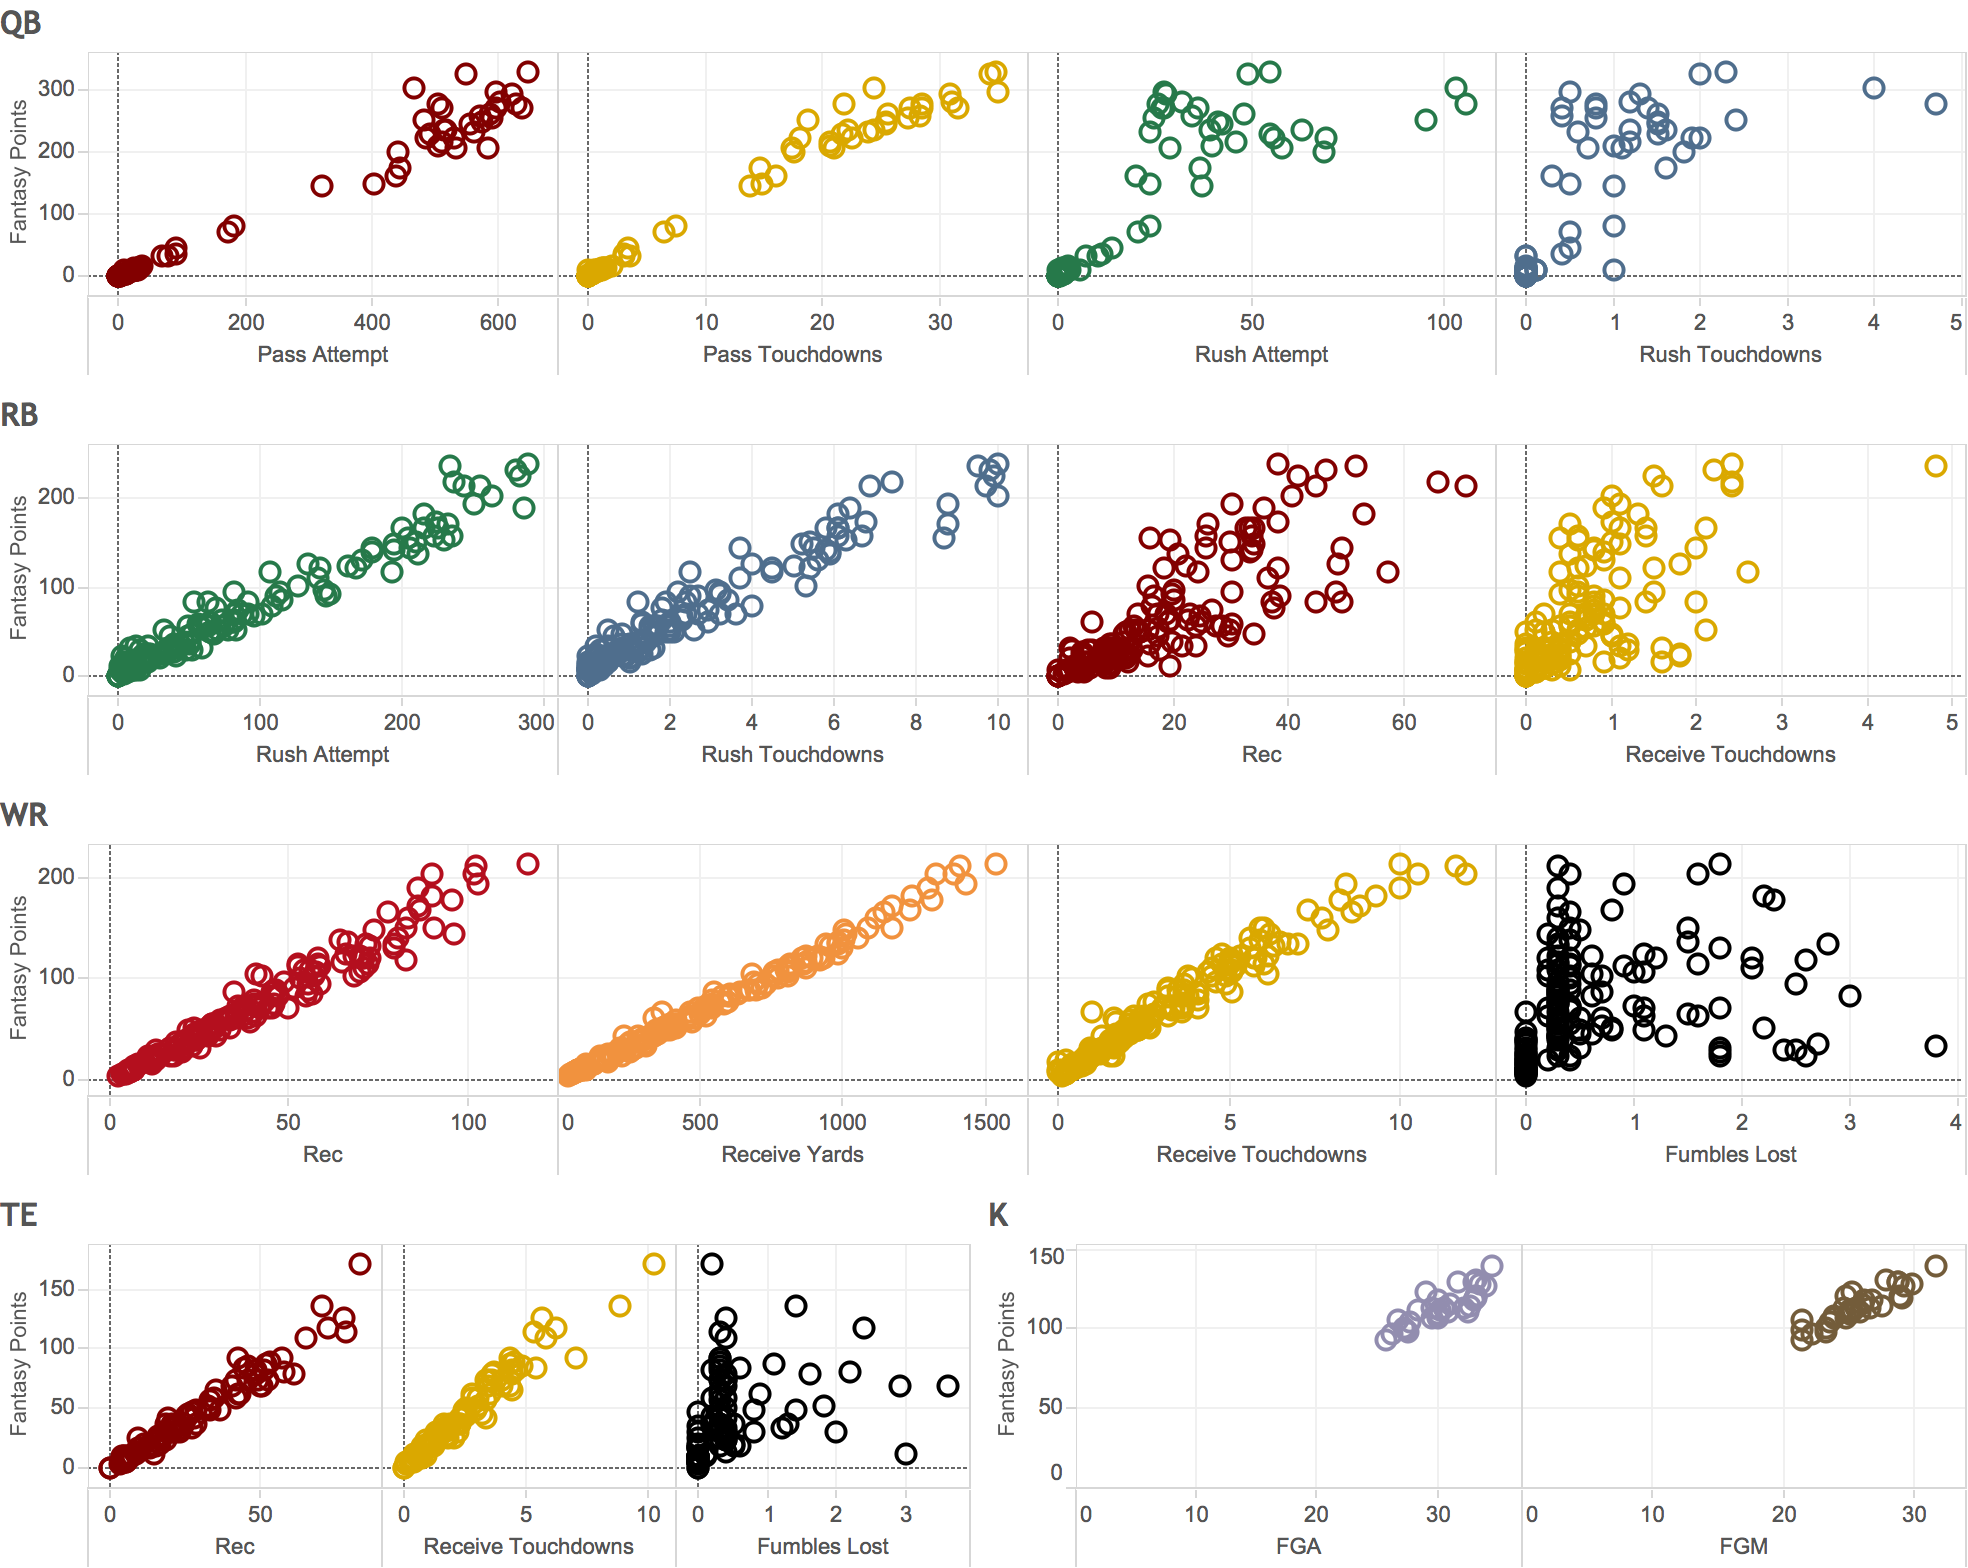

In [7]:
from IPython.display import Image
from IPython.display import display

#scatter plot of projected stats for each positions
x = Image(filename='asset/Positions.png')

#display all the images
display(x)

# Data Mining for 2015 Actual Results

In [8]:
#actual fantasy points
soup_results = BeautifulSoup(requests.get('https://www.fantasypros.com/nfl/reports/leaders/').text,'lxml')

data_results = [i.text for i in soup_results('table')[0].findAll('td')]

column_results = ['Rank','Player', 'Team','Position','Total_Points','Games_Played','Avg_Points']
dfResults = pd.DataFrame(list(group(data_results,7)),columns=column_results)
dfResults.head()

,Rank,Player,Team,Position,Total_Points,Games_Played,Avg_Points
0,1,Cam Newton,CAR,QB,389.1,16,24.3
1,2,Tom Brady,NE,QB,343.7,16,21.5
2,3,Russell Wilson,SEA,QB,336.4,16,21.0
3,4,Blake Bortles,JAC,QB,316.1,16,19.8
4,5,Carson Palmer,ARI,QB,309.2,16,19.3


# Setting up Postgresql Database

In [9]:
#!brew install postgresql
#!brew services stop postgresql
!brew services start postgresql
#!createdb fantasyfootball


Service `postgresql` already started, use `brew services restart postgresql` to restart.


In [10]:
#create an engine for localhost
engine = create_engine('postgresql://:@localhost:5432/fantasyfootball')

#lowercase all column names
dfQB.columns = [c.lower() for c in dfQB.columns]
dfRB.columns = [c.lower() for c in dfRB.columns]
dfWR.columns = [c.lower() for c in dfWR.columns]
dfTE.columns = [c.lower() for c in dfTE.columns]
dfK.columns = [c.lower() for c in dfK.columns]
dfResults.columns = [c.lower() for c in dfResults.columns]

#write data frames to their own tables
#dfQB.to_sql("qb", engine)
#dfRB.to_sql("rb", engine)
#dfWR.to_sql("wr", engine)
#dfTE.to_sql("te", engine)
#dfK.to_sql("k", engine)
#dfResults.to_sql('results',engine)

#connect to the engine
connection = engine.connect()

#query the player name, team they were on, and projected fantasy points
joinedQB = pd.read_sql("""
                        SELECT results.player,results.team,qb.position,qb.fantasy_points
                        FROM results
                        JOIN qb 
                        ON results.player=qb.player
                        ;""",con=engine)

joinedRB = pd.read_sql("""
                        SELECT results.player,results.team,rb.position,rb.fantasy_points
                        FROM results
                        JOIN rb 
                        ON results.player=rb.player
                        ;""",con=engine)

joinedWR = pd.read_sql("""
                        SELECT results.player,results.team,wr.position,wr.fantasy_points
                        FROM results
                        JOIN wr 
                        ON results.player=wr.player
                        ;""",con=engine)

joinedTE = pd.read_sql("""
                        SELECT results.player,results.team,te.position,te.fantasy_points
                        FROM results
                        JOIN te 
                        ON results.player=te.player
                        ;""",con=engine)

joinedK = pd.read_sql("""
                        SELECT results.player,results.team,k.position, k.fantasy_points
                        FROM results
                        JOIN k 
                        ON results.player=k.player
                        ;""",con=engine)

#concatenate the tables into one big table
frames = [joinedQB, joinedRB, joinedWR, joinedTE, joinedK]

finalFrame = pd.concat(frames)
finalFrame.head()


,player,team,position,fantasy_points
0,Cam Newton,CAR,QB,278.9
1,Tom Brady,NE,QB,281.2
2,Russell Wilson,SEA,QB,303.2
3,Blake Bortles,JAC,QB,205.5
4,Carson Palmer,ARI,QB,232.8


In [11]:
#drop names that doesn't exist in the other table and drop duplicates
somethingNew = (dfResults.loc[dfResults['player'].isin(finalFrame['player'])])
somethingNew = somethingNew.drop_duplicates(['player'],keep='last')

somethingWeird = (finalFrame.loc[finalFrame['player'].isin(dfResults['player'])])
somethingWeird = somethingWeird.drop_duplicates(['player'], keep='last')
somethingWeird['fantasy_points'] = somethingWeird['fantasy_points'].astype(float)

#join on the name of players, clean columns, rename some columns
newDF = pd.merge(somethingNew, somethingWeird, on='player')
newDF.drop(['rank','avg_points','team_y','position_y'],axis=1,inplace=True)
#newDF = newDF[['player','team','position_x','games_played','total_points','fantasy_points']]
newDF = newDF.rename(index=str, columns={"team_x": "team",
                                         "total_points": "actual",
                                         "fantasy_points":"projected",
                                         "position_x":"position"})

newDF = newDF[['player','team','position','games_played','actual','projected']]
newDF['games_played'] = newDF['games_played'].astype(int)
newDF['actual'] = newDF['actual'].astype(float)
newDF.describe()

,games_played,actual,projected
count,484.000000,484.000000,484.000000
mean,11.039256,72.452479,75.336777
std,4.506323,71.845169,69.557935
min,1.000000,-4.100000,0.000000
25%,8.000000,15.375000,20.250000
50%,12.000000,51.650000,54.950000
75%,15.000000,113.000000,112.925000
max,16.000000,389.100000,329.600000


# Projected vs Actual from the experts

R-squared: 0.764088696657


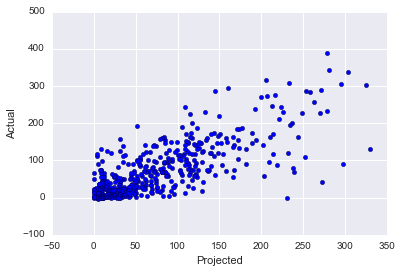

In [48]:
#plot projected vs actual
x = newDF.projected.tolist()
y = newDF.actual.tolist()
plt.scatter(x,y)
plt.xlabel('Projected')
plt.ylabel('Actual')

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(newDF['projected'].astype(float),newDF['actual'].astype(float))
print"R-squared:", r_value

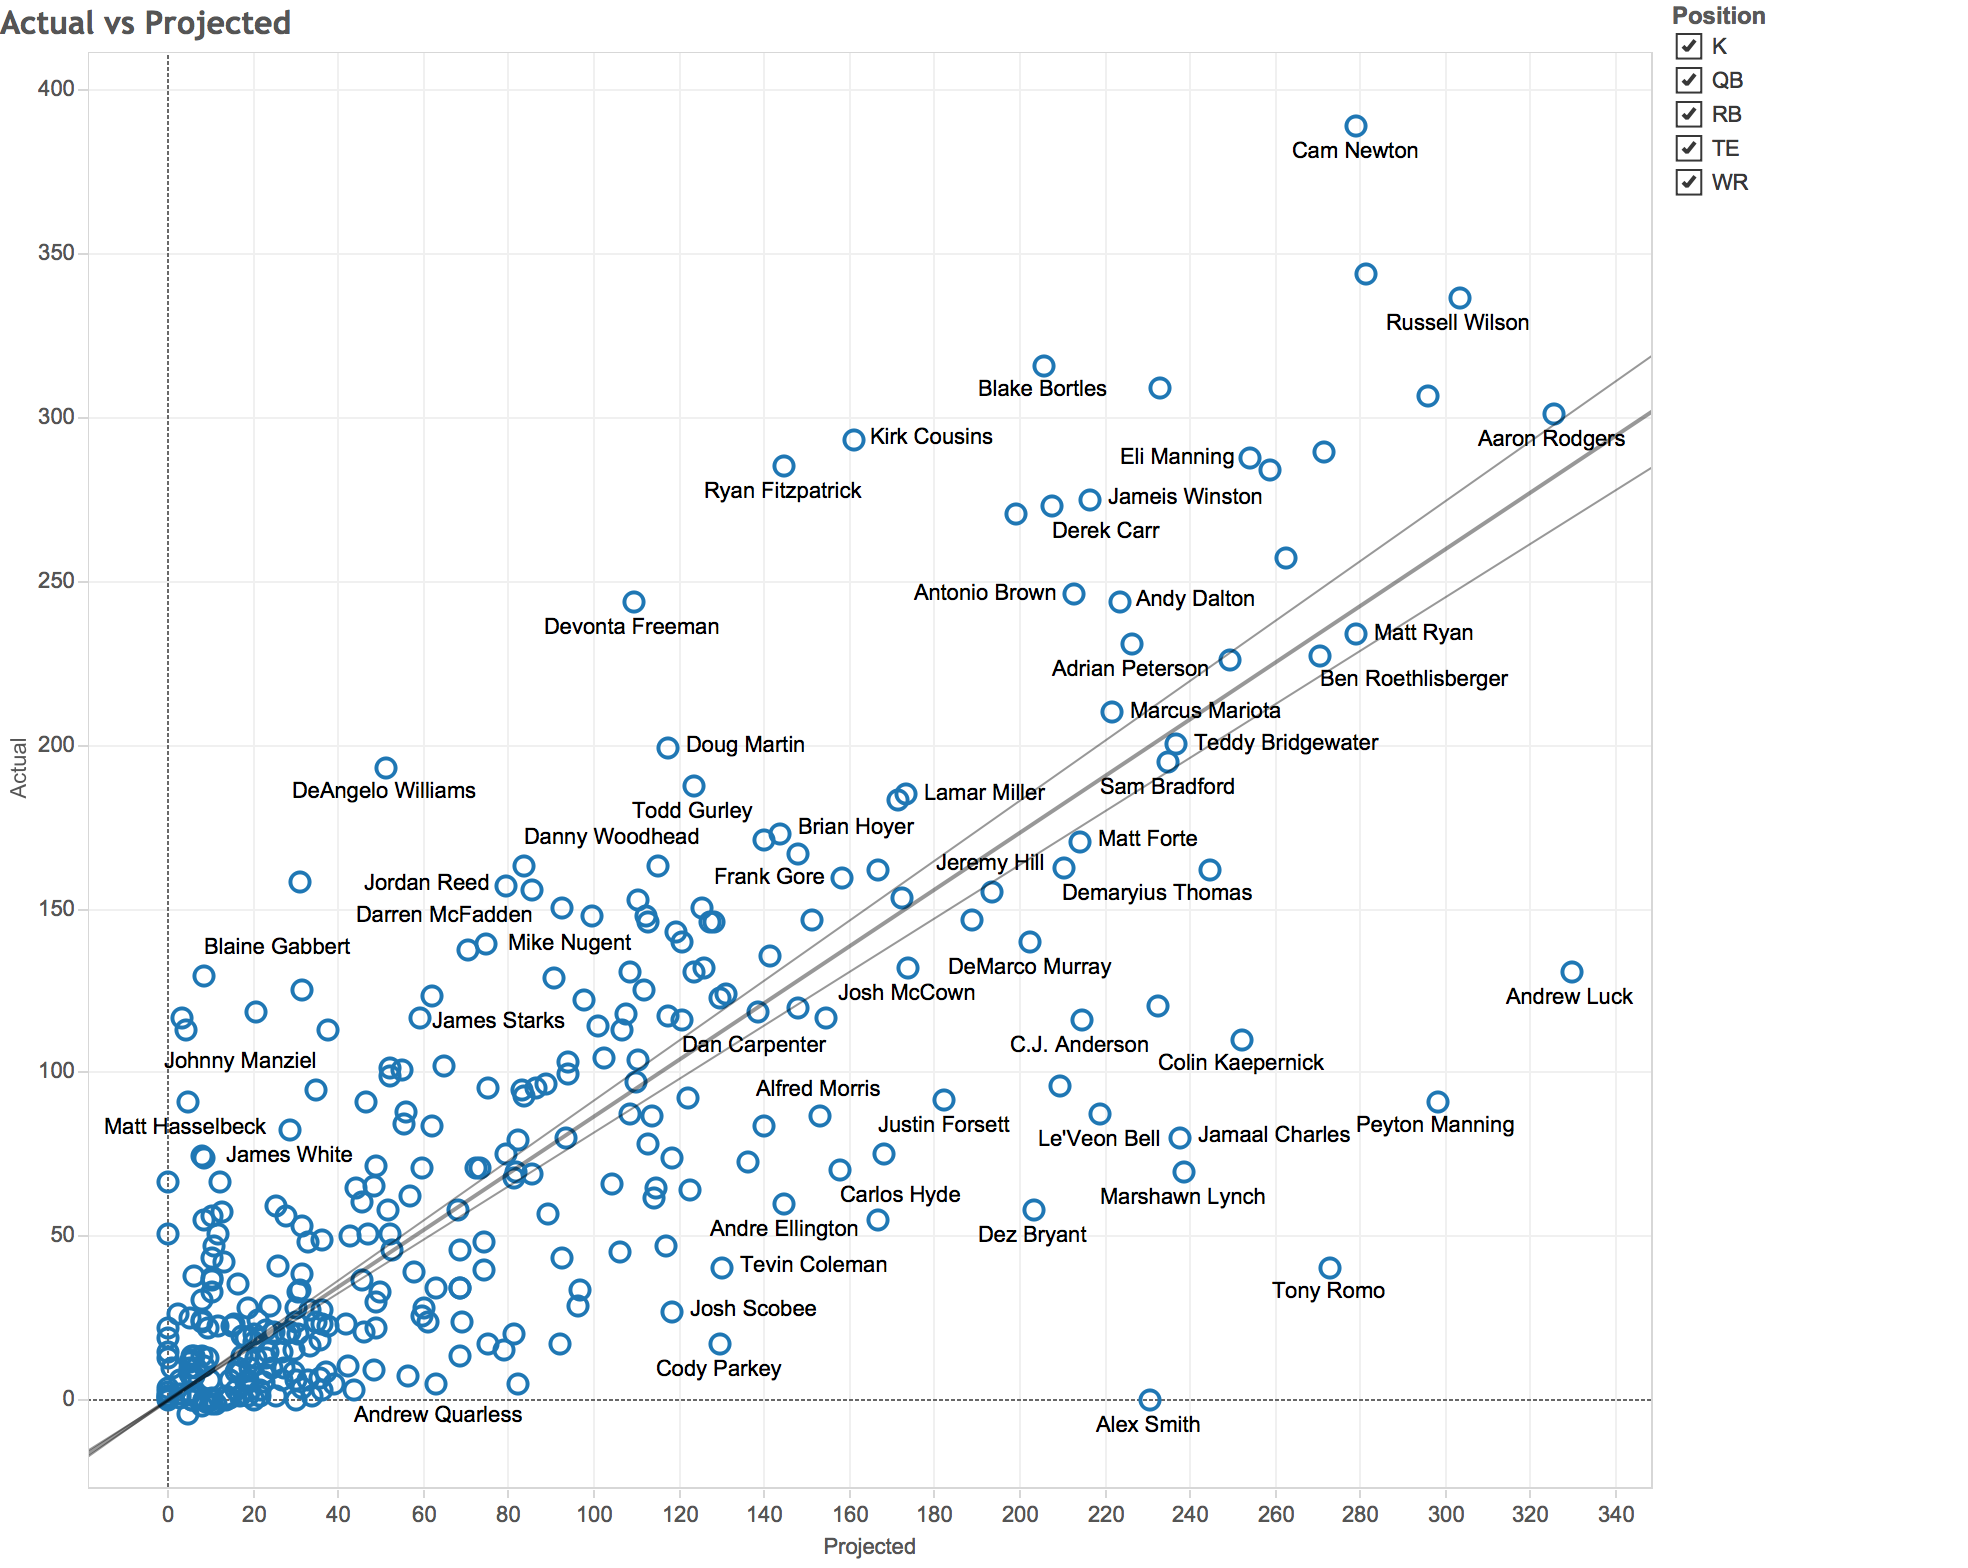

R-squared value: 0.78614


In [13]:
#scatter plot with a trend line for actual vs projected
y = Image(filename='asset/Actual vs Projected.png')
display(y)
print "R-squared value: 0.78614"

You can see that certain players like Cam Newton and Alex Smith was an outlier. You also have to be mindful that the projections assume that no players will get injured. Even though there are always injuries mid-season. 

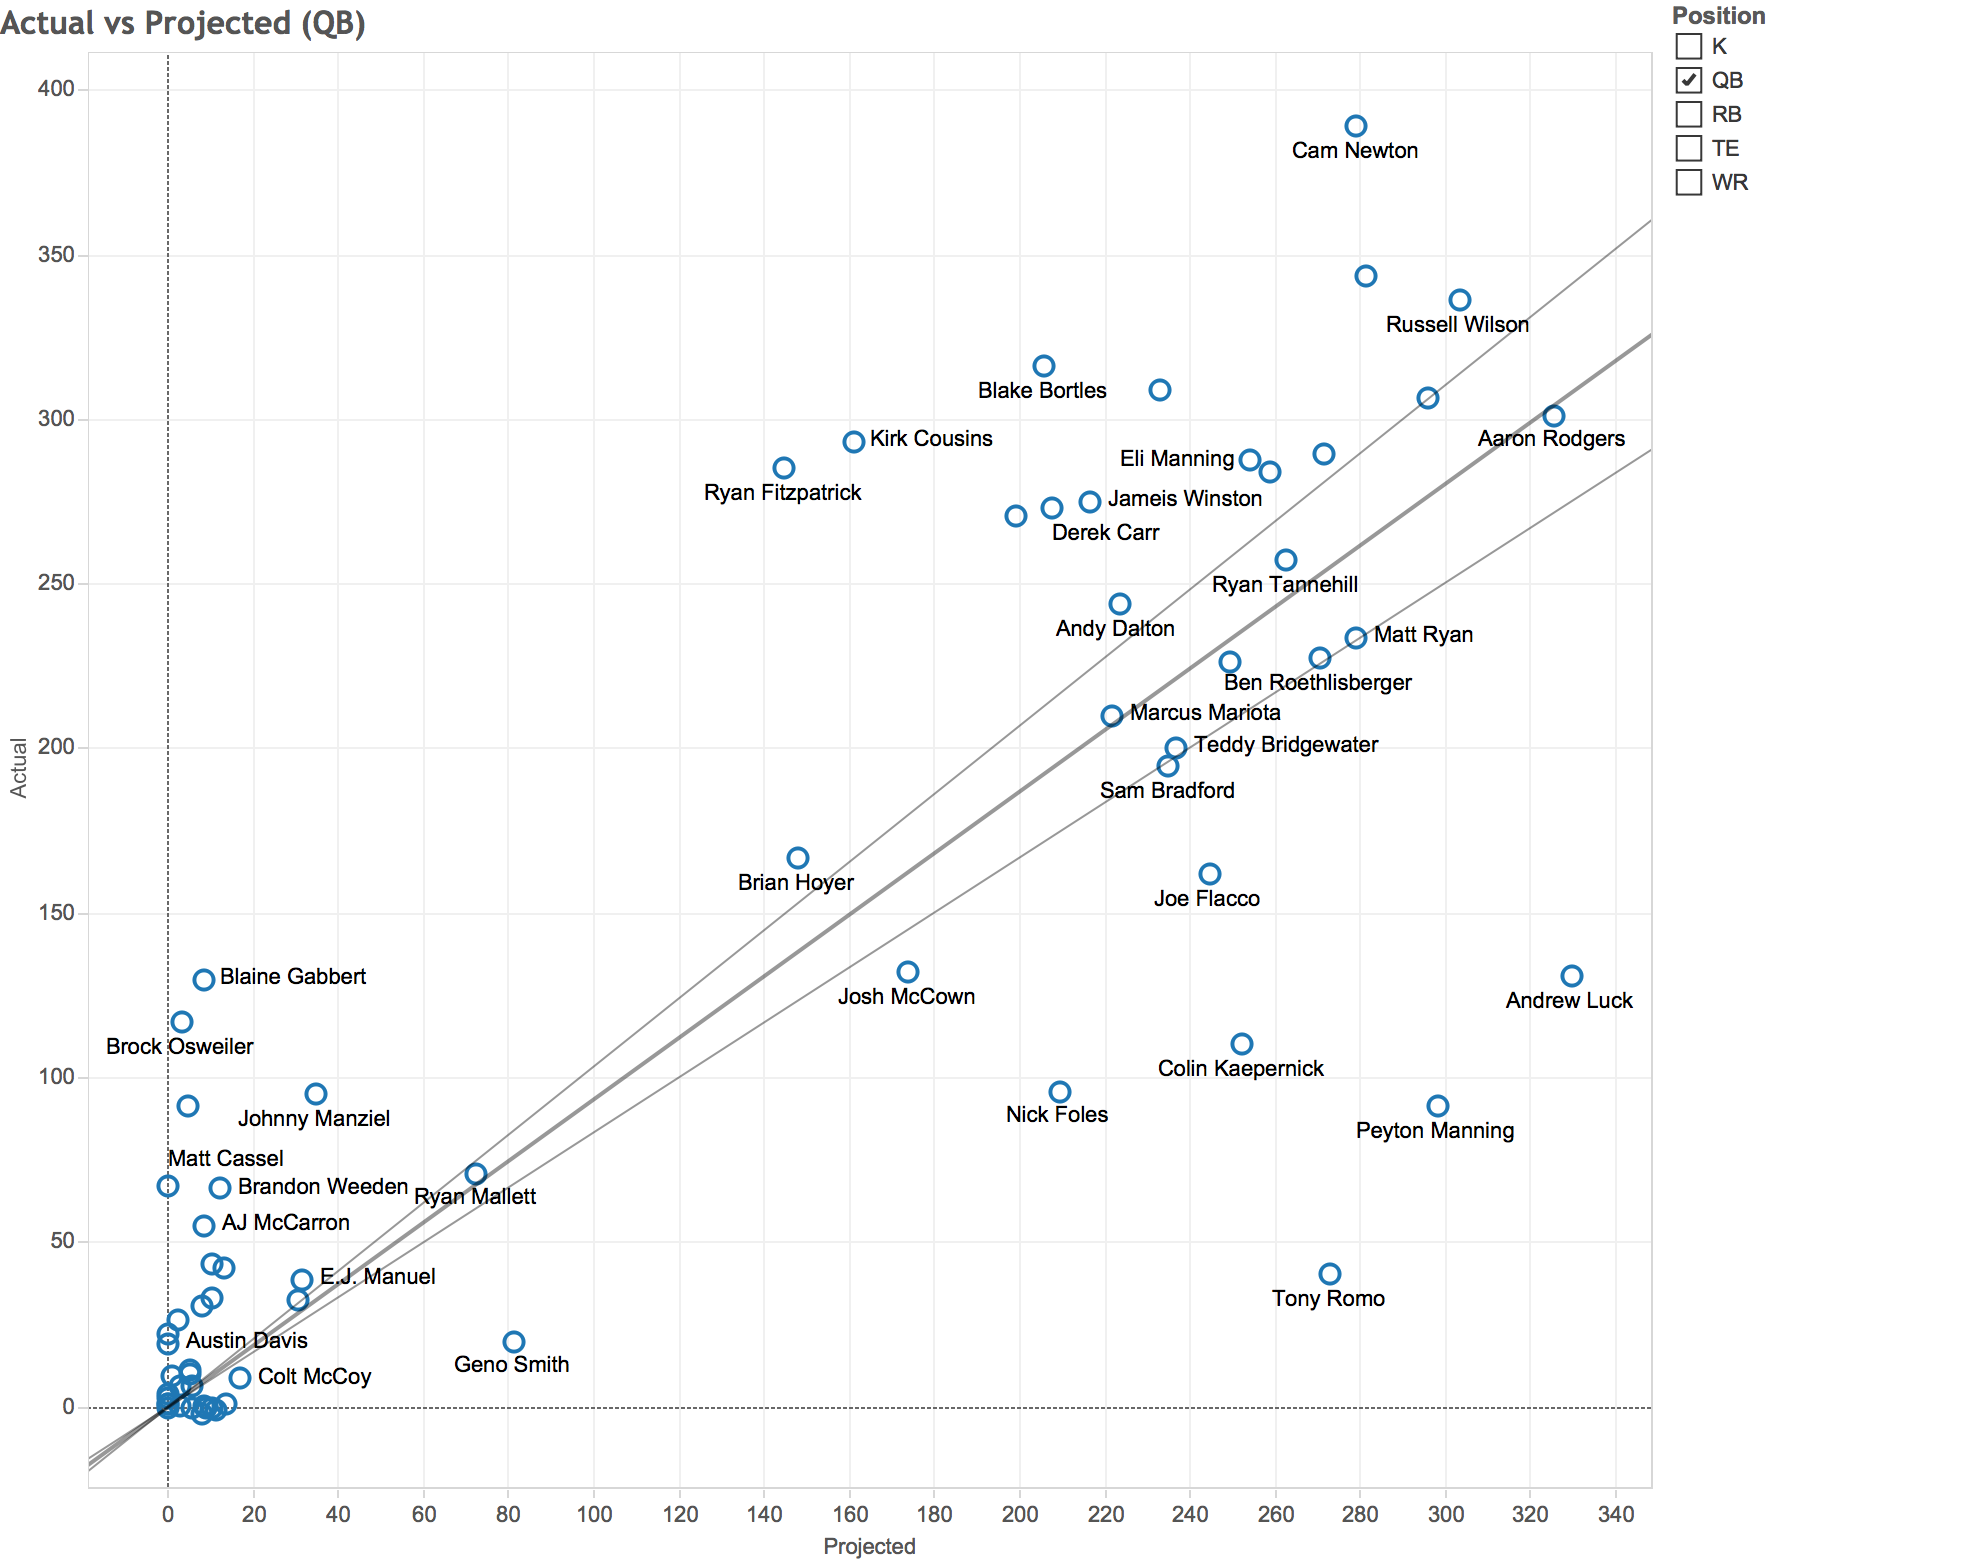

R-squared value for QB: 0.838384


In [14]:
#scatter plot with trendline for QBs only
q = Image(filename='asset/Actual vs Projected QB.png')
display(q)
print "R-squared value for QB: 0.838384"

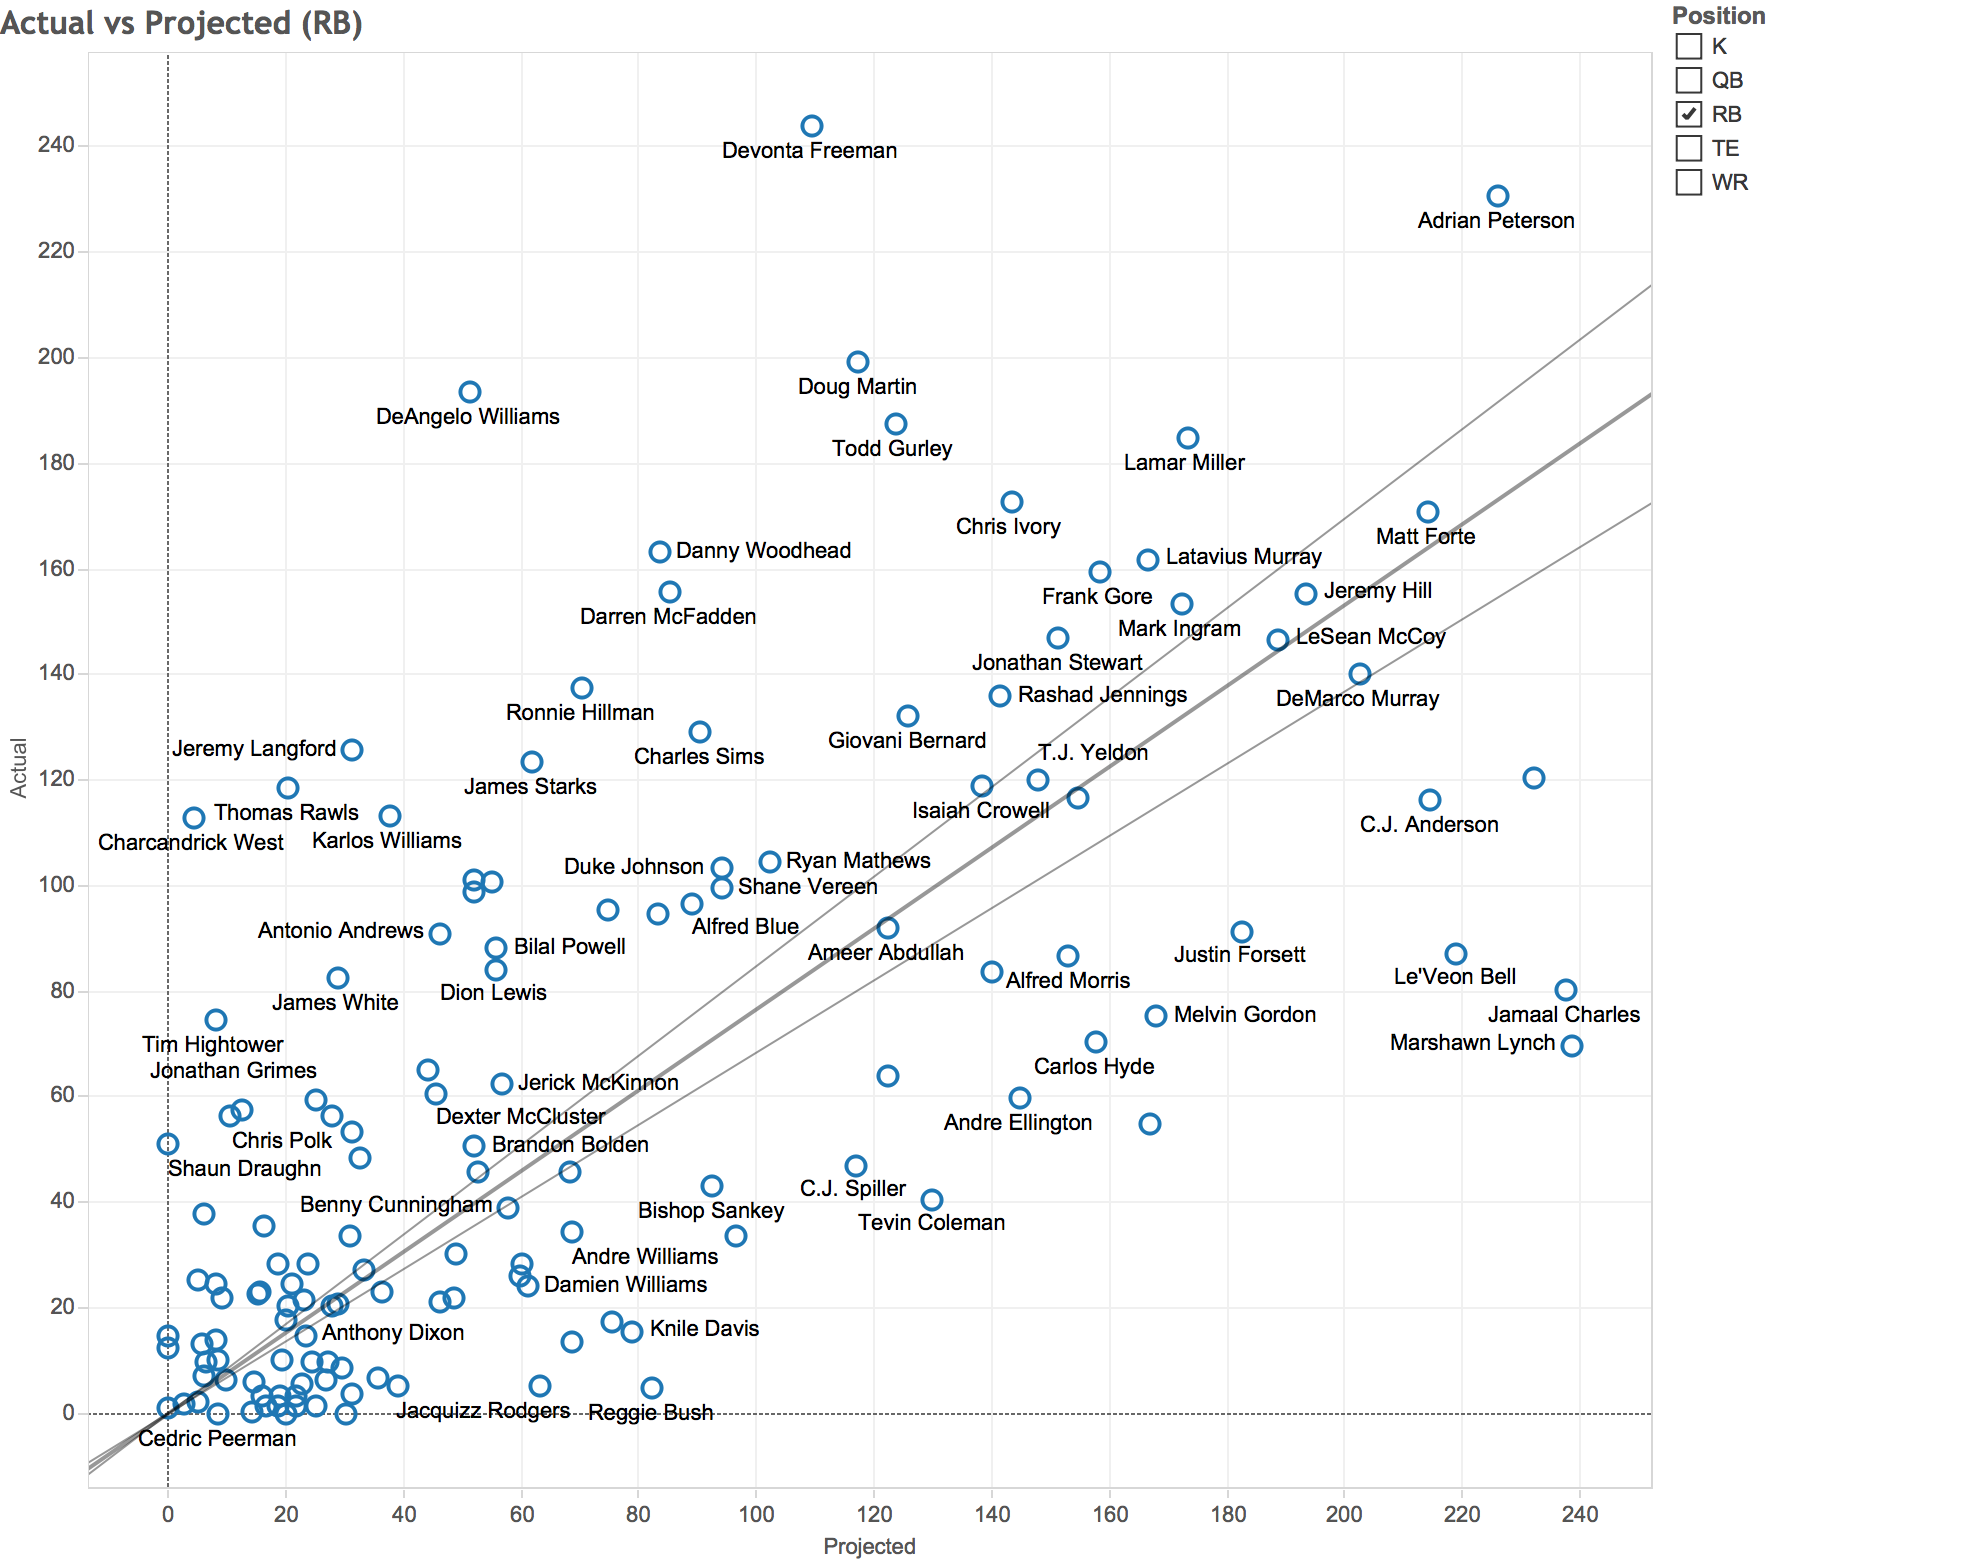

R-squared value for RB: 0.713983


In [15]:
#scatter plot with trendline for RBs only
r = Image(filename='asset/Actual vs Projected RB.png')
display(r)
print "R-squared value for RB: 0.713983"

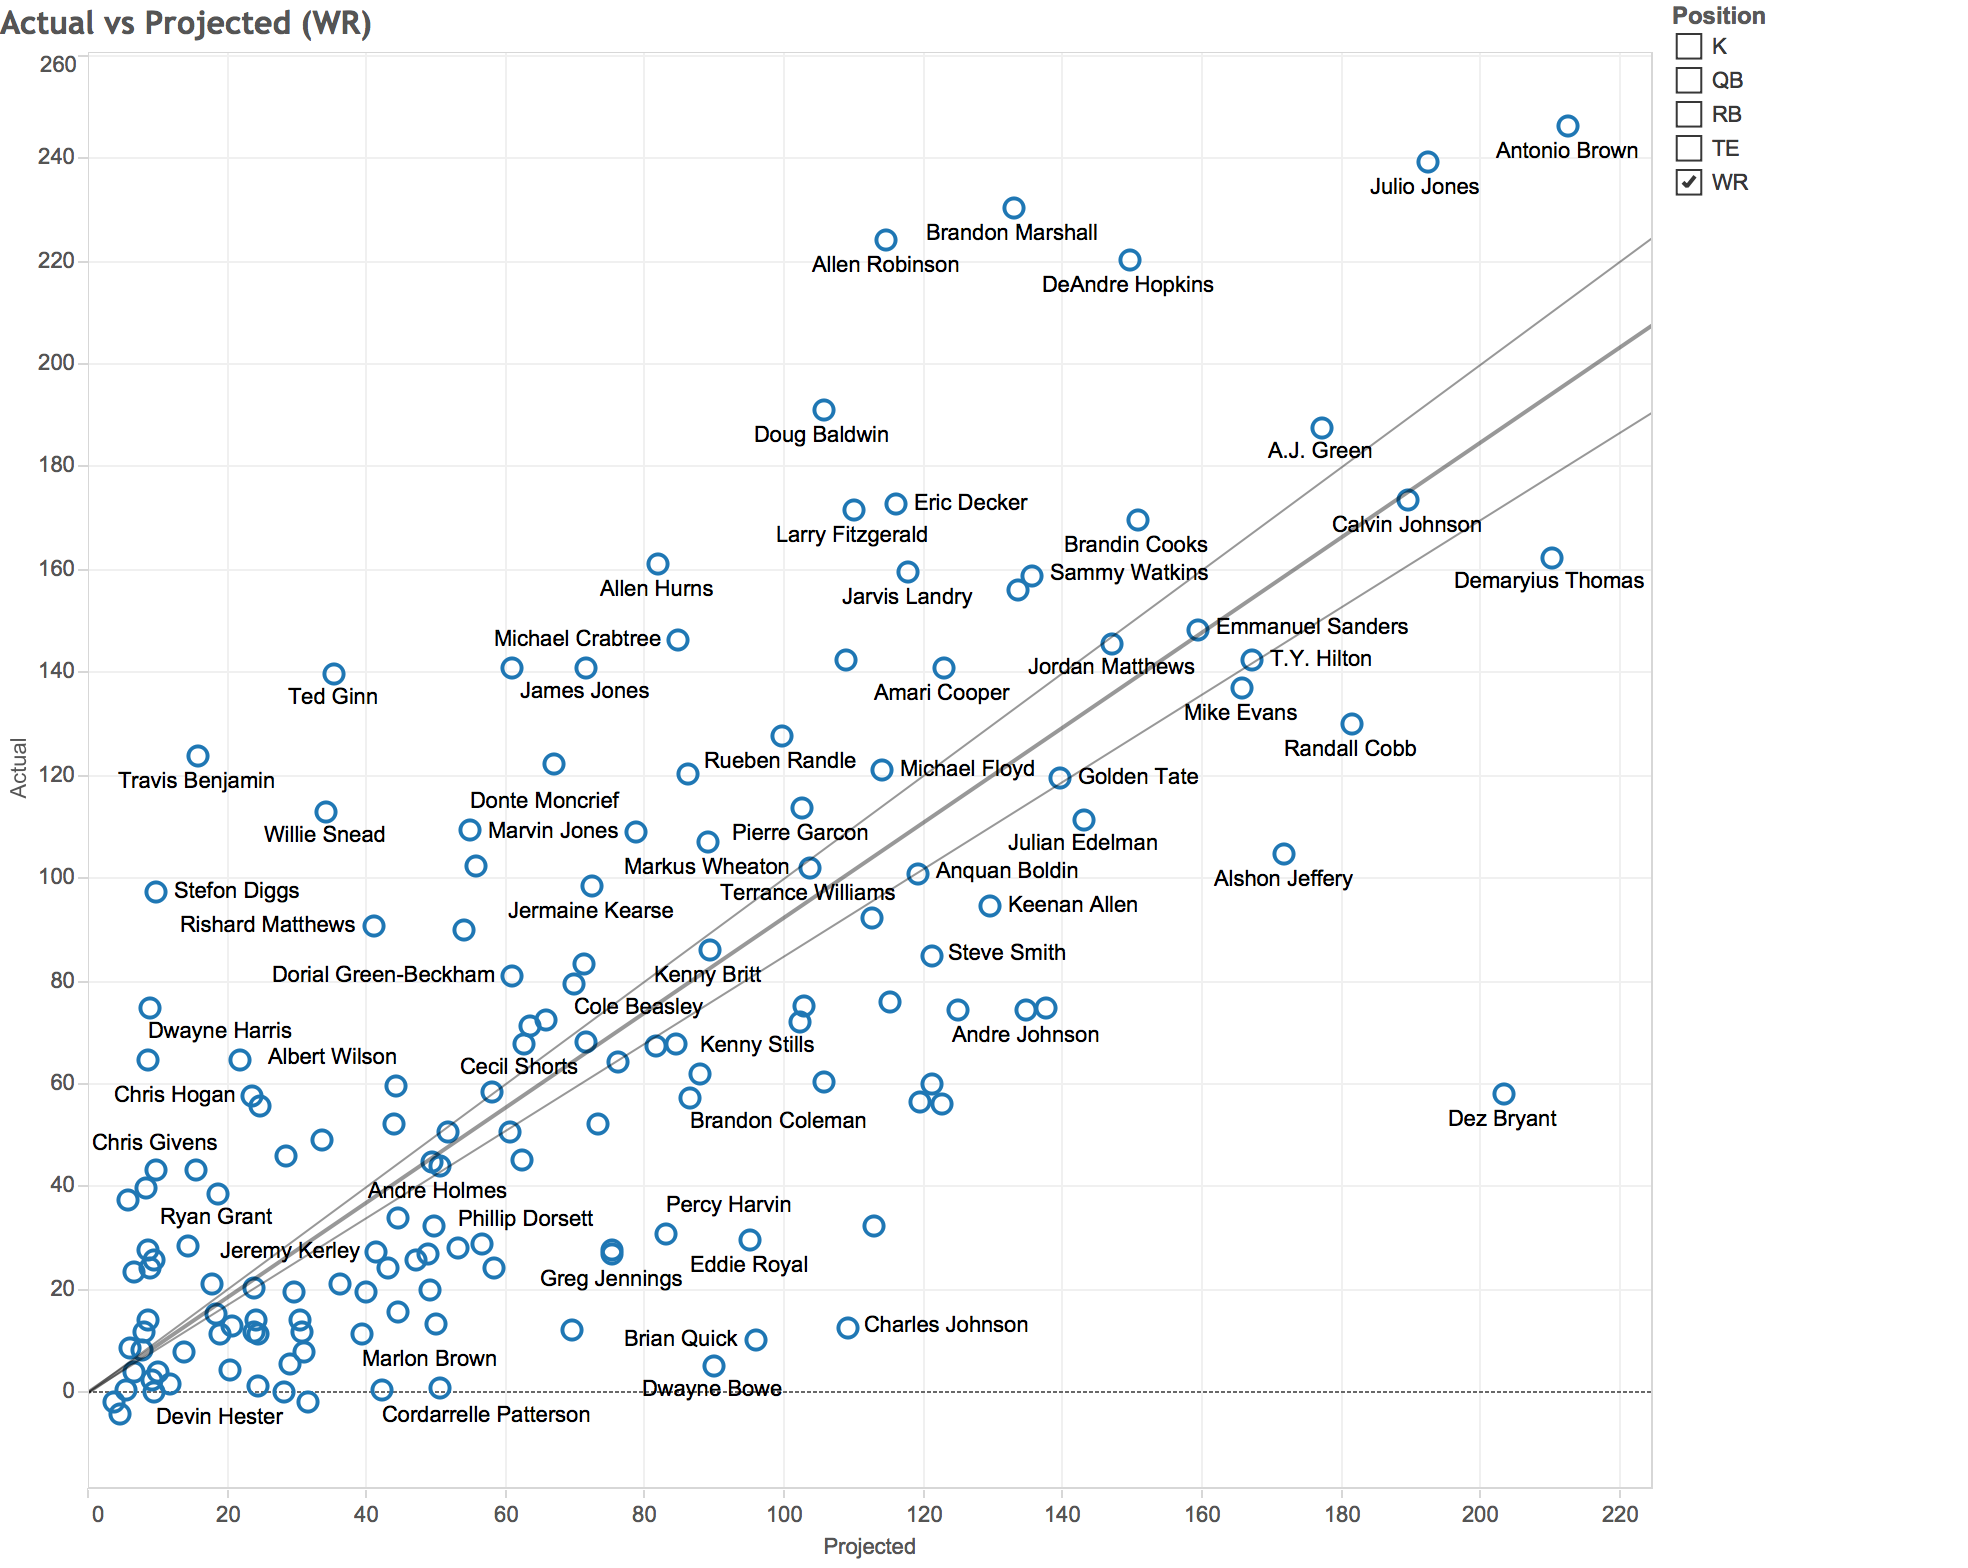

R-squared value for WR: 0.790042


In [16]:
#scatter plot with trendline for RBs only
w = Image(filename='asset/Actual vs Projected WR.png')
display(w)
print "R-squared value for WR: 0.790042"

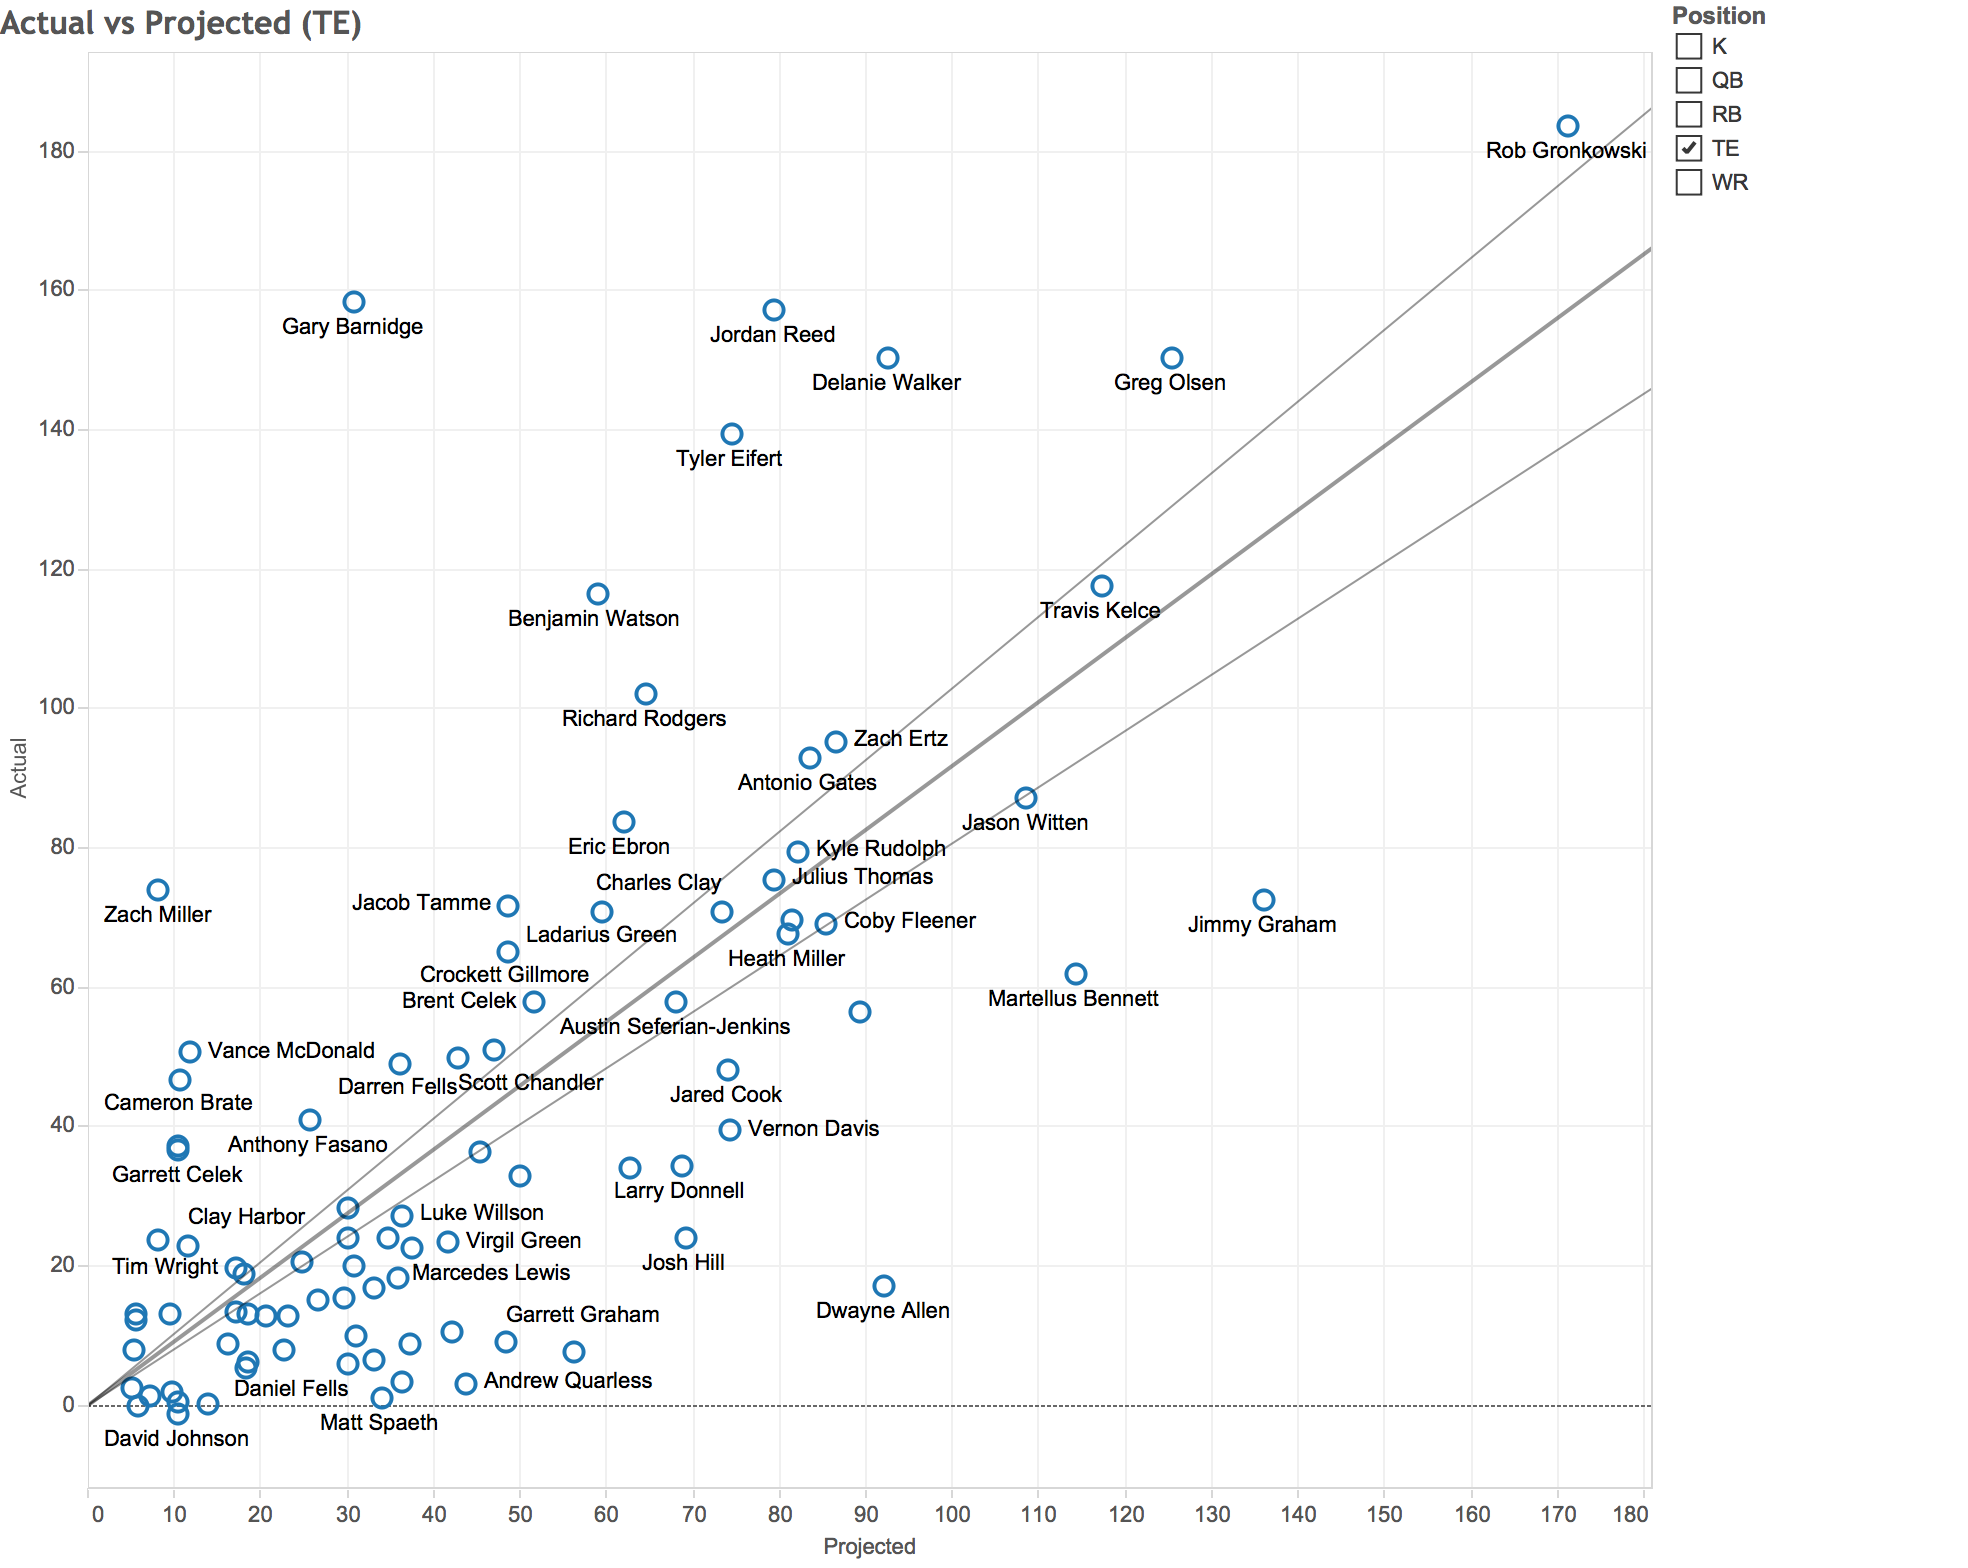

R-squared value for TE: 0.753236


In [17]:
#scatter plot with trendline for TEs only
t = Image(filename='asset/Actual vs Projected TE.png')
display(t)
print "R-squared value for TE: 0.753236"

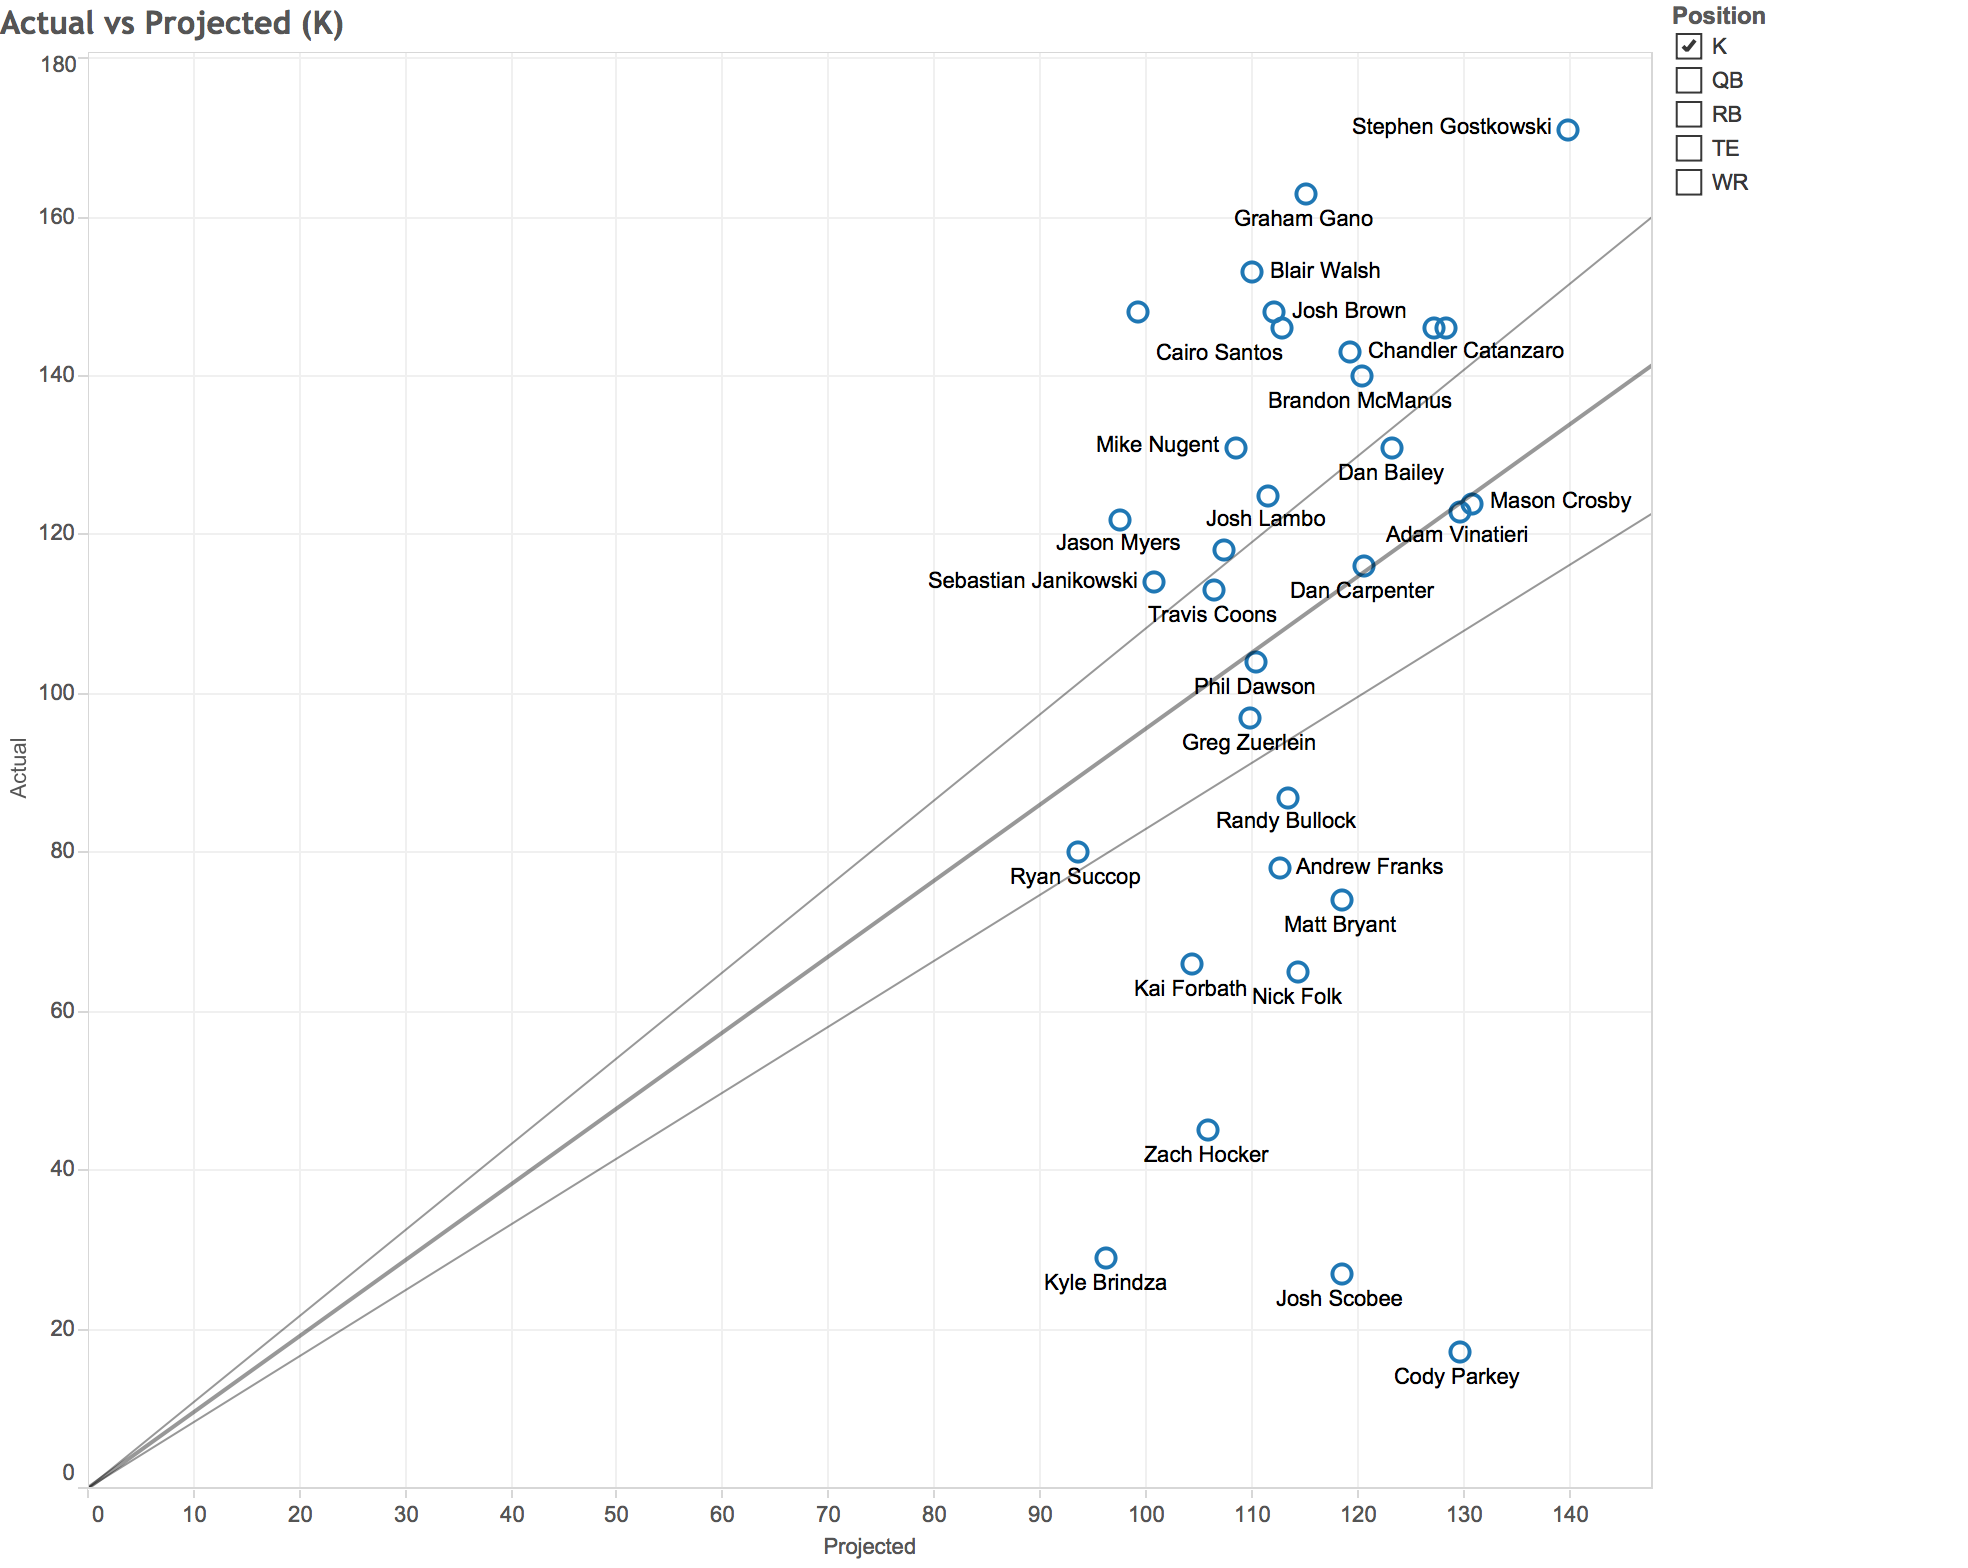

R-squared value for K: 0.884961


In [18]:
#scatter plot with trendline for TEs only
k = Image(filename='asset/Actual vs Projected K.png')
display(k)
print "R-squared value for K: 0.884961"

# Data Mining for 2014 results

In [19]:
URLQB1 = "http://fftoday.com/stats/playerstats.php?Season=2014&GameWeek=Season&PosID=10&LeagueID=10"
URLQB2 = "http://fftoday.com/stats/playerstats.php?Season=2014&GameWeek=Season&PosID=10&LeagueID=1&order_by=FFPts&sort_order=DESC&cur_page=1"

#parse the page
soupQB1 = BeautifulSoup(requests.get(URLQB1).text)
soupQB2 = BeautifulSoup(requests.get(URLQB2).text)

#get the data from the first page
QB1_data = [[i for i in soupQB1('table')[9].findAll('tr')[0]('tr')[i].text.split()[1:]] 
               for i in range(len(soupQB1('table')[9].findAll('tr')[0]('tr')))]
columnNames = ['First','Last','Team','Games','Comp_P','Att_P','Yards_P','TD_P','INT','ATT_R','Yards_R','TD_R','FPTs','FPTs/G','d']


dfQB12014 = pd.DataFrame(QB1_data[2:],columns=columnNames)

#merge first name and last name into one column
dfQB12014['First'] = dfQB12014[[0,1]].apply(lambda x: ' '.join(x),axis=1)
del dfQB12014['d']
del dfQB12014['Last']

#get the data from the second page
QB2_data = [[i for i in soupQB2('table')[9].findAll('tr')[0]('tr')[i].text.split()[1:]] 
               for i in range(len(soupQB2('table')[9].findAll('tr')[0]('tr')))]

columnNames = ['First','Last','Team','Games','Comp_P','Att_P','Yards_P','TD_P','INT','ATT_R','Yards_R','TD_R','FPTs','FPTs/G']

#merge first name and last name into one column
dfQB22014 = pd.DataFrame(QB2_data[2:],columns=columnNames)
dfQB22014['First'] = dfQB22014[[0,1]].apply(lambda x: ' '.join(x),axis=1)
del dfQB22014['Last']

#put both tables together
dfQB2014 = pd.concat([dfQB12014,dfQB22014])
dfQB2014.rename(columns={'First': 'Player'}, inplace=True)

#strip the commas
dfQB2014['Yards_P'] = dfQB2014['Yards_P'].str.replace(',', '')

#convert objects into numeric(integers or floats)
dfQB2014 = dfQB2014.convert_objects(convert_numeric=True)

#add a new column for completion rate, total yards, total touchdowns, yards per completions
dfQB2014['Comp_Rate'] = dfQB2014['Comp_P']/dfQB2014['Att_P']
dfQB2014['Total_Yards'] = dfQB2014['Yards_P'] + dfQB2014['Yards_R']
dfQB2014['Total_TD'] = dfQB2014['TD_P'] + dfQB2014['TD_R']
dfQB2014['Total_Yards_perComp'] = dfQB2014['Total_Yards']/dfQB2014['Comp_P']

dfQB2014.head()

/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Player,Team,Games,Comp_P,Att_P,Yards_P,TD_P,INT,ATT_R,Yards_R,TD_R,FPTs,FPTs/G,Comp_Rate,Total_Yards,Total_TD,Total_Yards_perComp
0,Andrew Luck,IND,16.0,380,616,4761,40.0,16,64,263,3,442.4,27.6,0.616883,5024,43.0,13.221053
1,Aaron Rodgers,GB,16.0,341,520,4381,38.0,5,43,269,2,410.0,25.6,0.655769,4650,40.0,13.636364
2,Drew Brees,NO,16.0,456,659,4952,33.0,17,27,68,1,392.4,24.5,0.691958,5020,34.0,11.008772
3,Peyton Manning,DEN,16.0,395,597,4727,39.0,15,24,-24,0,390.0,24.4,0.661642,4703,39.0,11.906329
4,Ben Roethlisberger,PIT,16.0,408,608,4952,32.0,9,32,27,0,378.3,23.6,0.671053,4979,32.0,12.203431


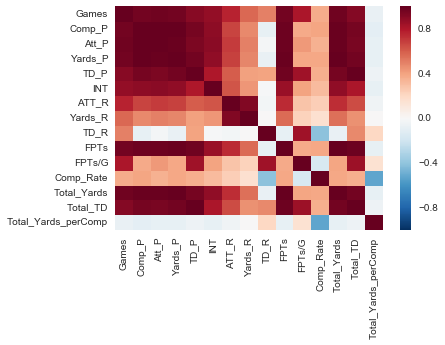

In [20]:
sns.heatmap(dfQB2014.corr())

# Building a simple model

In [21]:
dfQB2014.rename(columns={'Player': 'player'}, inplace=True)

In [22]:
resultQB = pd.merge(dfQB2014, somethingNew, on='player')

In [23]:
resultQB.drop(['team','position','games_played','avg_points'],inplace=True,axis=1)


/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


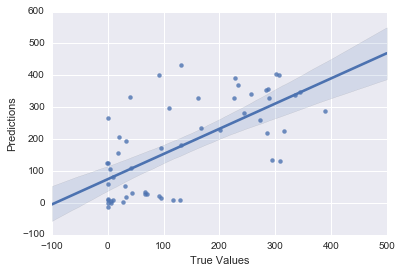

R2 value for Lin Reg: 0.310893


/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


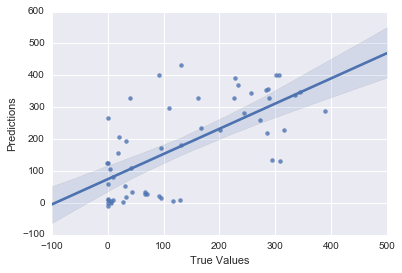

R2 value for Lasso: 0.310849


In [24]:
from sklearn import linear_model
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score


X_QB = resultQB[['Total_Yards','Total_TD','Total_Yards_perComp']]
y_QB = resultQB[['FPTs']]

X_QB = X_QB.convert_objects(convert_numeric=True)
y_QB = y_QB.convert_objects(convert_numeric=True)


X_QB.replace([np.inf, -np.inf], np.nan,inplace=True)
y_QB = y_QB.drop(y_QB.index[[-1]])
X_QB.dropna(inplace=True)


#Building a model using the train sets and test sets
lm = linear_model.LinearRegression()

model = lm.fit(X_QB, y_QB)
predictions = lm.predict(X_QB)
target = resultQB[['total_points']].astype(float)
target = target.drop(target.index[[-1]])

## The line / model
#plt.scatter(target,predictions)
sns.regplot(target,np.ravel(predictions))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
#print "Score:", model.score(X_QB, target)  
#print("Mean Square Error: %.2f" % np.mean(((predictions - target) ** 2)/len(X_QB)))
print "R2 value for Lin Reg: %f" % r2_score(predictions, target) 

ll = linear_model.LassoCV(alphas=[0.01, 1, 100]).fit(X_QB,y_QB)

predictions1 = ll.predict(X_QB)

sns.regplot(target,predictions1)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

#print("Mean Square Error: %.2f" % np.mean((([predictions1] - target) ** 2)/len(predictions1)))
print "R2 value for Lasso: %f" % r2_score(predictions1, target) 
#use the 2015 results and try it on the model

#use a diff method to model it

Best score: 69.1328406326
Best depth: 5


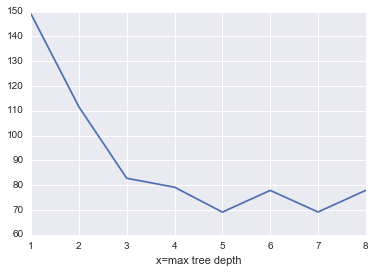

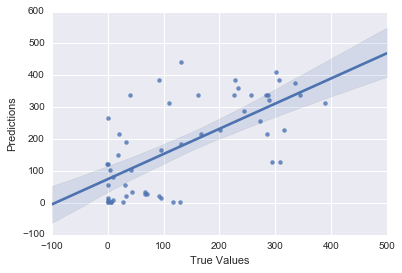

R2 value for decision tree: 0.309421


In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold, cross_val_score

all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 9):
    treereg = DecisionTreeRegressor(max_depth=i,random_state=5)
    scores = cross_val_score(treereg, X_QB, y_QB, cv=3, n_jobs = -1, scoring='mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # If the score mean is better than the current best, or best is the default (-1), then update!
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print "Best score: %s" % best_score
print "Best depth: %s" % best_depth

# now actually fit the model
treereg = DecisionTreeRegressor(max_depth=best_depth,random_state=5)
#X_train, X_test, y_train, y_test = train_test_split(X_QB, y_QB, test_size=0.3)
treereg.fit(X_QB, y_QB)

plt.figure()
plt.plot(range(1, 9), all_scores)
plt.xlabel('x=max tree depth')
plt.show()

preds = treereg.predict(X_QB)

sns.regplot(target,preds)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
print "R2 value for decision tree: %f" % r2_score(preds, target) 


/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipyker

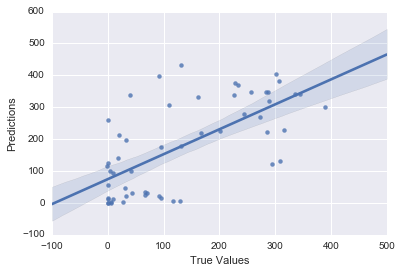

R2 value for Random Forest: 0.308251


In [26]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
rf = RandomForestRegressor()
rfScore = cross_val_score(rf,X_QB,y_QB,cv=3,verbose=True,n_jobs=-1)
rf.fit(X_QB, y_QB)

preds_rf = rf.predict(X_QB)

sns.regplot(target,preds_rf)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
print "R2 value for Random Forest: %f" % r2_score(preds_rf, target) 

#print predictions, predictions1,preds,preds_rf

The R^2 value for all these models are generally around 0.3. There are no models that stood out significnatly although some were slightly better than others. However, this still does not beat the R^2 values of the experts. There must be some other factors that will contribute to making a better model.

In [27]:
URLRB1 = "http://fftoday.com/stats/playerstats.php?Season=2014&GameWeek=Season&PosID=20&LeagueID=0"
URLRB2 = "http://fftoday.com/stats/playerstats.php?Season=2014&GameWeek=Season&PosID=20&LeagueID=1&order_by=FFPts&sort_order=DESC&cur_page=3"

#parse the page
soupRB1 = BeautifulSoup(requests.get(URLRB1).text)
soupRB2 = BeautifulSoup(requests.get(URLRB2).text)

RB1_data = [[i for i in soupRB1('table')[9].findAll('tr')[0]('tr')[i].text.split()[1:]] 
               for i in range(len(soupRB1('table')[9].findAll('tr')[0]('tr')))]
columnNames = ['First','Last','Team','Games', 'Att_Rush','Yards_Rush','TD_Rush','Target','RecNum','Yards_Rec','TD_Rec','FPTs','FPTs/G']


dfRB12014 = pd.DataFrame(RB1_data[2:],columns=columnNames)

dfRB12014['First'] = dfRB12014[[0,1]].apply(lambda x: ' '.join(x),axis=1)
del dfRB12014['Last']

RB2_data = [[i for i in soupRB2('table')[9].findAll('tr')[0]('tr')[i].text.split()[1:]] 
               for i in range(len(soupRB2('table')[9].findAll('tr')[0]('tr')))]

dfRB22014 = pd.DataFrame(RB2_data[2:],columns=columnNames)
dfRB22014['First'] = dfRB22014[[0,1]].apply(lambda x: ' '.join(x),axis=1)
del dfRB22014['Last']

dfRB2014 = pd.concat([dfRB12014,dfRB22014])
dfRB2014.rename(columns={'First': 'Player'}, inplace=True)
dfRB2014['Yards_Rush'] = dfRB2014['Yards_Rush'].str.replace(',','')

#convert objects into numeric(integers or floats)
dfRB2014 = dfRB2014.convert_objects(convert_numeric=True)

dfRB2014.head()

/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Player,Team,Games,Att_Rush,Yards_Rush,TD_Rush,Target,RecNum,Yards_Rec,TD_Rec,FPTs,FPTs/G
0,DeMarco Murray,DAL,16,393,1845,13,64,57,416,0,304.1,19.0
1,Le'Veon Bell,PIT,16,290,1361,8,105,83,854,3,287.5,18.0
2,Marshawn Lynch,SEA,16,280,1306,13,48,37,367,4,269.3,16.8
3,Matt Forte,CHI,16,266,1038,6,130,102,808,4,244.6,15.3
4,Arian Foster,HOU,13,260,1246,8,59,38,327,5,235.3,18.1


In [28]:
dfRB2014.rename(columns={'Player': 'player'}, inplace=True)
resultRB = pd.merge(dfRB2014, somethingNew, on='player')
resultRB = resultRB.convert_objects(convert_numeric=True)
resultRB['Total_Yards'] = resultRB['Yards_Rush'] + resultRB['Yards_Rec']
resultRB['Total_TD'] = resultRB['TD_Rush'] + resultRB['TD_Rec']
resultRB['Att'] = resultRB['Att_Rush'] + resultRB['RecNum']
resultRB['Total_Yards_perComp'] = resultRB['Total_Yards'] / resultRB['Att']
resultRB.drop(['team','position','games_played','avg_points'],inplace=True,axis=1)
resultRB.head()

/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


,player,Team,Games,Att_Rush,Yards_Rush,TD_Rush,Target,RecNum,Yards_Rec,TD_Rec,FPTs,FPTs/G,rank,total_points,Total_Yards,Total_TD,Att,Total_Yards_perComp
0,DeMarco Murray,DAL,16,393,1845,13,64,57,416,0,304.1,19.0,96,140.1,2261,13,450,5.024444
1,Le'Veon Bell,PIT,16,290,1361,8,105,83,854,3,287.5,18.0,198,87.2,2215,11,373,5.938338
2,Marshawn Lynch,SEA,16,280,1306,13,48,37,367,4,269.3,16.8,239,69.7,1673,17,317,5.277603
3,Matt Forte,CHI,16,266,1038,6,130,102,808,4,244.6,15.3,50,170.7,1846,10,368,5.016304
4,Arian Foster,HOU,13,260,1246,8,59,38,327,5,235.3,18.1,281,55.0,1573,13,298,5.278523


/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


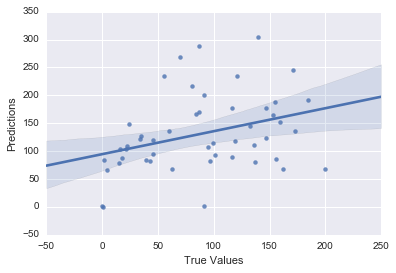

R2 value: -0.500779


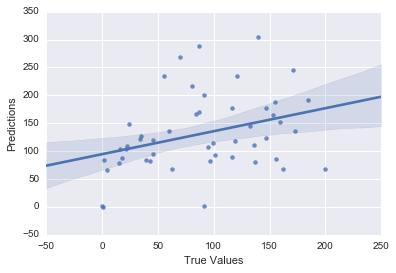

R2 value: -0.500746


In [29]:
X_RB = resultRB[['Total_Yards','Total_TD','Total_Yards_perComp']]
y_RB = resultRB[['FPTs']]

#X_RB = X_RB.convert_objects(convert_numeric=True)
#y_RB = y_RB.convert_objects(convert_numeric=True)

X_RB.replace([np.inf, -np.inf], np.nan,inplace=True)
y_RB = y_RB.drop(y_RB.index[[-1]])
y_RB = y_RB.drop(y_RB.index[[-1]])
X_RB.dropna(inplace=True)

#Building a model using the train sets and test sets
lm = linear_model.LinearRegression()

model = lm.fit(X_RB, y_RB)
predictions = lm.predict(X_RB)
target = resultRB[['total_points']].astype(float)
target = target.drop(target.index[[-1]])
target = target.drop(target.index[[-1]])

## The line / model
sns.regplot(target,np.ravel(predictions))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
#print "Score:", model.score(X_QB, target)  
#print("Mean Square Error: %.2f" % np.mean(((predictions - target) ** 2)/len(X_QB)))
print "R2 value: %f" % r2_score(predictions, target) 

ll = linear_model.LassoCV(alphas=[0.01, 1, 100]).fit(X_RB,np.ravel(y_RB))

predictions1 = ll.predict(X_RB)

sns.regplot(target,predictions1)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

#print("Mean Square Error: %.2f" % np.mean((([predictions1] - target) ** 2)/len(predictions1)))
print "R2 value: %f" % r2_score(predictions1, target) 


Best score: 53.4480580985
Best depth: 8


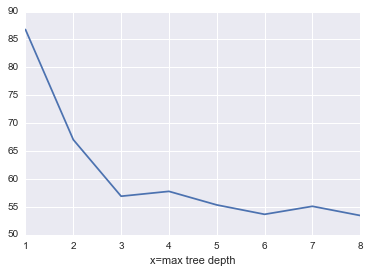

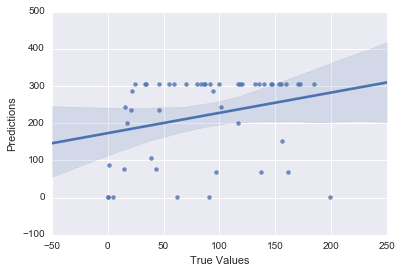

R2 value: -1.344554


In [30]:
all_scores = []
best_score = -1
best_depth = 0
for i in range(1, 9):
    treereg = DecisionTreeRegressor(max_depth=i)
    scores = cross_val_score(treereg, X_RB, y_RB, cv=3, n_jobs = -1, scoring='mean_squared_error')
    current_score = np.mean(np.sqrt(-scores))
    # If the score mean is better than the current best, or best is the default (-1), then update!
    if current_score < best_score or best_score == -1:
        best_score = current_score
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print "Best score: %s" % best_score
print "Best depth: %s" % best_depth

# now actually fit the model
treereg = DecisionTreeRegressor(max_depth=best_depth)
#X_train, X_test, y_train, y_test = train_test_split(X_QB, y_QB, test_size=0.3)
treereg.fit(X_RB, y_RB)

plt.figure()
plt.plot(range(1, 9), all_scores)
plt.xlabel('x=max tree depth')
plt.show()

preds = treereg.predict(X_QB)

sns.regplot(target,preds[:49])
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
print "R2 value: %f" % r2_score(preds[:49], target) 


/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/SangYeob/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:1531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/Users/SangYeob/anaconda/lib/python2.7/site-packages/ipyker

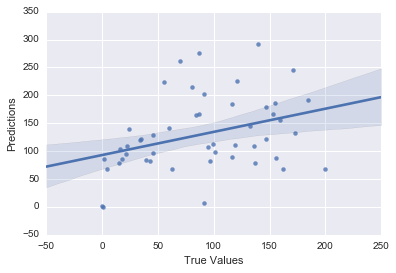

R2 value: -0.507564


In [31]:
rf = RandomForestRegressor()
rfScore = cross_val_score(rf,X_RB,y_RB,cv=3,verbose=True,n_jobs=-1)
rf.fit(X_RB, y_RB)

preds_rf = rf.predict(X_RB)

sns.regplot(target,preds_rf)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()
print "R2 value: %f" % r2_score(preds_rf, target) 

The R-squared values for all the models that I have tested on the quarter backs and running backs tell me that the stats from previous years cannot predict better than the expert's preseason predictions. There are a lot more factors than purely stats that contribute to the fantasy points at the end of the season. To make a better model, I need to investigate further into how experts are coming up with their predictions, and include other features such as team ranking injuries,and other stats.

# Clustering Algorithms
Since my own models were not successful, I will use the expert predictions to cluster players into tiers to recommend who you should draft.

In [32]:
finalFrame['fantasy_points'] = finalFrame['fantasy_points'].astype(float)
finalFrame.sort_values(by='fantasy_points',axis=0,ascending=False,inplace=True)
finalFrame.reset_index(inplace=True,drop=True)
#finalFrame.drop(['index'],axis=1,inplace=True)
finalFrame.head(20)


,player,team,position,fantasy_points
0,Andrew Luck,IND,QB,329.6
1,Aaron Rodgers,GB,QB,325.2
2,Russell Wilson,SEA,QB,303.2
3,Peyton Manning,FA,QB,298.0
4,Drew Brees,NO,QB,295.6
5,Tom Brady,NE,QB,281.2
6,Cam Newton,CAR,QB,278.9
7,Matt Ryan,ATL,QB,278.8
8,Tony Romo,DAL,QB,272.9
9,Matthew Stafford,DET,QB,271.3


Estimated number of clusters: 29


/Users/SangYeob/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


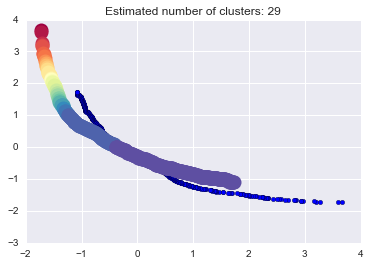

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

finalFrame['Rank'] = finalFrame.index + 1

data = finalFrame[['Rank','fantasy_points']]
data = data.as_matrix().astype("float32", copy = False)

stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)

dataDF = pd.DataFrame(data)
plt.scatter(dataDF[1],dataDF[0])

dbsc = DBSCAN(eps = .035, min_samples =1).fit(data)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
clusters = [data[labels == i] for i in xrange(n_clusters_)]

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = data[class_member_mask & core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = data[class_member_mask & ~core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [34]:
tempDF = finalFrame
tempDF['tier'] = labels
fantasyP = tempDF['fantasy_points'].groupby(tempDF['tier']).mean()

mydict = {}
for x in range(len(tempDF)):
    currentcluster = tempDF.iloc[x,5]
    currentvalue = tempDF.iloc[x,[0,2]]
    mydict.setdefault(currentcluster, [])
    mydict[currentcluster].append(currentvalue)

dbscanDF = pd.DataFrame([[key,value] for key,value in mydict.items()],columns=["cluster","player"])
dbscanDF['fantasy_points'] = fantasyP
dbscanDF.head(10)

,cluster,player,fantasy_points
0,0,"[[Andrew Luck, QB]]",329.600000
1,1,"[[Aaron Rodgers, QB]]",325.200000
2,2,"[[Russell Wilson, QB]]",303.200000
3,3,"[[Peyton Manning, QB]]",298.000000
4,4,"[[Drew Brees, QB]]",295.600000
5,5,"[[Tom Brady, QB], [Cam Newton, QB], [Matt Ryan...",279.633333
6,6,"[[Tony Romo, QB], [Matthew Stafford, QB], [Ben...",271.500000
7,7,"[[Ryan Tannehill, QB]]",262.700000
8,8,"[[Philip Rivers, QB]]",258.800000
9,9,"[[Eli Manning, QB], [Colin Kaepernick, QB]]",253.100000


In [35]:
playerList3 = []
pointList3 = []
for i in dbscanDF.player:
    for x in i:
        playerList3.append(x)

compDict = {}
for x in range(len(dbscanDF)):
    currentPlayer = dbscanDF.iloc[x,1]
    currentFantasy = dbscanDF.iloc[x,2].astype(str).split()
    fantasyP5 = [x for x in range(len(currentPlayer)) for x in currentFantasy]
    pointList3.append(fantasyP5)

newDBSCAN = pd.DataFrame(playerList3)
newDBSCAN['projected'] = [item for sublist in pointList3 for item in sublist]
newDBSCAN.sort_values(by='projected',axis=0,ascending=False,inplace=True)
newDBSCAN = pd.merge(newDBSCAN, newDF, on='player')
newDBSCAN.drop(['position_y','projected_y'],axis=1,inplace=True)
newDBSCAN = newDBSCAN.rename(index=str, columns={"position_x": "position",
                                         "projected_x": "projected",
                                         })

newDBSCAN = newDBSCAN[['player','position','team','games_played','projected','actual']]
newDBSCAN['diff'] = newDBSCAN['actual'].astype(float) - newDBSCAN['projected'].astype(float)
newDBSCAN['projected'] = newDBSCAN['projected'].astype(float)
newDBSCAN.sort_values(by='projected',axis=0,ascending=False,inplace=True)
newDBSCAN['diffPerGame'] = newDBSCAN['actual'].astype(float)/(newDBSCAN['games_played'].astype(float)) - \
                            newDBSCAN['projected'].astype(float)/16
newDBSCAN.head()

,player,position,team,games_played,projected,actual,diff,diffPerGame
0,Andrew Luck,QB,IND,7,329.6,130.8,-198.8,-1.914286
1,Aaron Rodgers,QB,GB,16,325.2,301.3,-23.9,-1.493750
2,Russell Wilson,QB,SEA,16,303.2,336.4,33.2,2.075000
304,Peyton Manning,QB,FA,10,298.0,91.3,-206.7,-9.495000
305,Drew Brees,QB,NO,15,295.6,306.5,10.9,1.958333


In [36]:
tempDF2 = finalFrame

In [37]:
from sklearn.cluster import KMeans
import numpy as np
kmeansTemp = tempDF2.iloc[:,3:]
kmean = KMeans(n_clusters=100, random_state=10) 

kmean.fit(kmeansTemp)

recomDF = finalFrame.drop(['tier'],axis=1)

recomDF['cluster'] =  kmean.labels_
recomDF['fantasy_points'] = recomDF['fantasy_points'].astype(float)
fantasyP = recomDF['fantasy_points'].groupby(recomDF['cluster']).mean()

kmeansDict = {}
for x in range(len(recomDF)):
    currentcluster = recomDF.iloc[x,5]
    currentvalue = recomDF.iloc[x,[0,2]]
    kmeansDict.setdefault(currentcluster, [])
    kmeansDict[currentcluster].append(currentvalue)


kmeansDF = pd.DataFrame([[key,value] for key,value in kmeansDict.items()],columns=["cluster","player"])
kmeansDF['fantasy_points'] = fantasyP
kmeansDF.sort_values(by='fantasy_points',axis=0,ascending=False,inplace=True)
kmeansDF.head()

,cluster,player,fantasy_points
7,7,"[[Andrew Luck, QB], [Aaron Rodgers, QB]]",327.400000
90,90,"[[Russell Wilson, QB]]",303.200000
27,27,"[[Peyton Manning, QB], [Drew Brees, QB]]",296.800000
56,56,"[[Tom Brady, QB], [Cam Newton, QB], [Matt Ryan...",279.633333
19,19,"[[Tony Romo, QB], [Matthew Stafford, QB], [Ben...",271.500000


In [38]:
playerList2 = []
pointList2 = []
for i in kmeansDF.player:
    for x in i:
        playerList2.append(x)

compDict = {}
for x in range(len(kmeansDF)):
    currentPlayer = kmeansDF.iloc[x,1]
    currentFantasy = kmeansDF.iloc[x,2].astype(str).split()
    fantasyP4 = [x for x in range(len(currentPlayer)) for x in currentFantasy]
    pointList2.append(fantasyP4)

newKmeans = pd.DataFrame(playerList2)
newKmeans['projected'] = [item for sublist in pointList2 for item in sublist]
newKmeans.sort_values(by='projected',axis=0,ascending=False,inplace=True)
newKmeans = pd.merge(newKmeans, newDF, on='player')
newKmeans.drop(['position_y','projected_y'],axis=1,inplace=True)
newKmeans = newKmeans.rename(index=str, columns={"position_x": "position",
                                         "projected_x": "projected",
                                         })

newKmeans = newKmeans[['player','position','team','games_played','projected','actual']]
newKmeans['diff'] = newKmeans['actual'].astype(float) - newKmeans['projected'].astype(float)
newKmeans['projected'] = newKmeans['projected'].astype(float)
newKmeans.sort_values(by='projected',axis=0,ascending=False,inplace=True)
newKmeans['diffPerGame'] = newKmeans['actual'].astype(float)/(newKmeans['games_played'].astype(float)) - \
                            newKmeans['projected'].astype(float)/16
newKmeans['diffPerGame'].describe()

count    491.000000
mean       1.097316
std        3.347989
min      -14.476562
25%       -0.689062
50%        0.646667
75%        2.619231
max       15.710714
Name: diffPerGame, dtype: float64

The data frame aboves gives recommendations for each rounds of fantasy draft. If a player runs out in the first group of players, then you should pick players from the next group of players. Each players in its groups weigh the same.

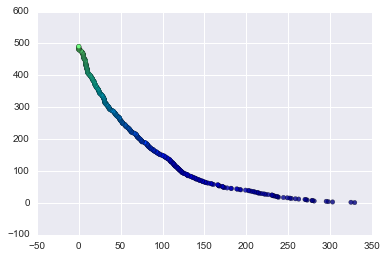

In [39]:
from sklearn import mixture
from pylab import *

samples = finalFrame.iloc[:,3:]
gmix = mixture.GMM(n_components=50, covariance_type='full')
gmix.fit(samples)
#print gmix.means_
tiers = gmix.predict(samples)
#colors = ['r' if i==0 else 'g' for i in gmix.predict(samples)]
ax = plt.gca()

from matplotlib import cm
from numpy import linspace

start = 0.0
stop = 1.0
number_of_lines= 1000
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.jet(x) for x in cm_subsection ]
ax.scatter(samples.iloc[:,0], samples.iloc[:,1], c=colors, alpha=0.8)
plt.show()


In [40]:
GaussDF = finalFrame
#GaussDF.drop('Rank',axis=1,inplace=True)
GaussDF['Tier'] = tiers
fantasyP2 = GaussDF['fantasy_points'].groupby(GaussDF['Tier']).mean()
GaussDF = GaussDF.drop('tier',axis=1)

mydict2 = {}
for x in range(len(GaussDF)):
    currentTier = GaussDF.iloc[x,5]
    currentvalue = GaussDF.iloc[x,[0,2]]
    mydict2.setdefault(currentTier, [])
    mydict2[currentTier].append(currentvalue)

GMMDF = pd.DataFrame([[key,value] for key,value in mydict2.items()],columns=["Tier","player"])
GMMDF['fantasy_points'] = [x for x in fantasyP2 if x != np.nan]
GMMDF.sort_values(by='fantasy_points',axis=0,ascending=False,inplace=True)
GMMDF.head()


,Tier,player,fantasy_points
17,18,"[[Andrew Luck, QB], [Aaron Rodgers, QB], [Russ...",305.466667
23,24,"[[Matt Ryan, QB], [Matthew Stafford, QB], [Rya...",270.933333
8,8,"[[Cam Newton, QB], [Tony Romo, QB], [Ben Roeth...",260.087500
25,26,"[[Marshawn Lynch, RB], [Jamaal Charles, RB], [...",234.287500
24,25,"[[Adrian Peterson, RB], [Andy Dalton, QB], [Ma...",218.450000


In [41]:
playerList = []
pointList = []
for i in GMMDF.player:
    for x in i:
        playerList.append(x)

compDict = {}
for x in range(len(GMMDF)):
    currentPlayer = GMMDF.iloc[x,1]
    currentFantasy = GMMDF.iloc[x,2].astype(str).split()
    fantasyP3 = [x for x in range(len(currentPlayer)) for x in currentFantasy]
    pointList.append(fantasyP3)

newGMM = pd.DataFrame(playerList)
newGMM['projected'] = [item for sublist in pointList for item in sublist]
newDF.sort_values(by='projected',axis=0,ascending=False,inplace=True)
newGMM = pd.merge(newGMM, newDF, on='player')
newGMM.drop(['position_y','projected_y'],axis=1,inplace=True)
newGMM = newGMM.rename(index=str, columns={"position_x": "position",
                                         "projected_x": "projected",
                                         })

newGMM = newGMM[['player','position','team','games_played','projected','actual']]
newGMM['diff'] = newGMM['actual'].astype(float) - newGMM['projected'].astype(float)
newGMM['diffPerGame'] = newGMM['actual'].astype(float)/(newGMM['games_played'].astype(float)) - newGMM['projected'].astype(float)/16
newGMM['diffPerGame'].describe()

count    491.000000
mean       1.097316
std        3.362074
min      -14.642969
25%       -0.643594
50%        0.691667
75%        2.546401
max       15.636250
Name: diffPerGame, dtype: float64

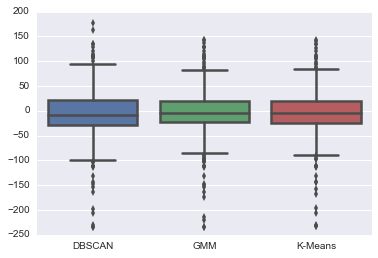

In [42]:
finalDiff = {'DBSCAN': newDBSCAN['diff'],
             'K-Means': newKmeans['diff'],
             'GMM': newGMM['diff']}
finalDiff = pd.DataFrame(finalDiff)
sns.boxplot(data=finalDiff, linewidth=2.5)

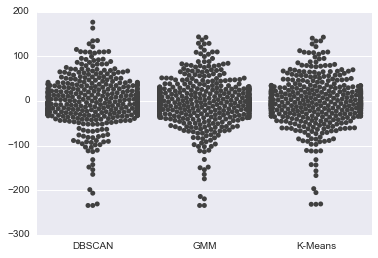

In [43]:
sns.swarmplot(data=finalDiff, color=".25")

In [44]:
print newDBSCAN['diff'].describe()
print newKmeans['diff'].describe()
print newGMM['diff'].describe()
print "The cluster algorithms produced a similar result. However, if you look at the 75% quartile, DBSCAN produced \
the highest value. When you are drafting players, it makes sense that you will pick from the top 25%."

count    491.000000
mean      -3.621181
std       51.156333
min     -234.287500
25%      -28.093355
50%       -8.393355
75%       22.006645
max      176.305785
Name: diff, dtype: float64
count    491.000000
mean      -3.621181
std       49.494618
min     -231.625000
25%      -24.265000
50%       -4.350000
75%       19.680000
max      142.733333
Name: diff, dtype: float64
count    491.000000
mean      -3.621181
std       49.425321
min     -234.287500
25%      -22.919948
50%       -5.080000
75%       19.821591
max      143.318182
Name: diff, dtype: float64
The cluster algorithms produced a similar result. However, if you look at the 75% quartile, DBSCAN produced the highest value. When you are drafting players, it makes sense that you will pick from the top 25%.


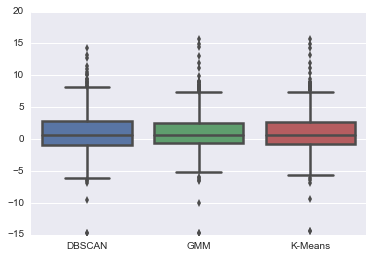

In [45]:
finalDiffPerGame = {'DBSCAN': newDBSCAN['diffPerGame'],
             'K-Means': newKmeans['diffPerGame'],
             'GMM': newGMM['diffPerGame']}
finalDiffPerGame = pd.DataFrame(finalDiffPerGame)
sns.boxplot(data=finalDiffPerGame, linewidth=2.5)

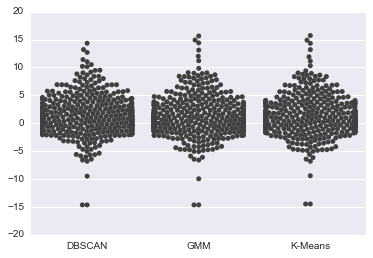

In [46]:
sns.swarmplot(data=finalDiffPerGame, color=".25")

In [47]:
print newDBSCAN['diffPerGame'].describe()
print newKmeans['diffPerGame'].describe()
print newGMM['diffPerGame'].describe()
print "This difference per game is showing you that the difference taking injuries into an account since it's the \
average difference per game. In this case, GMM performed the best in 75% quartile. All the quartiles below 75% \
quartile is irrelevant "


count    491.000000
mean       1.097316
std        3.391647
min      -14.642969
25%       -0.891487
50%        0.596354
75%        2.781665
max       14.325415
Name: diffPerGame, dtype: float64
count    491.000000
mean       1.097316
std        3.347989
min      -14.476562
25%       -0.689062
50%        0.646667
75%        2.619231
max       15.710714
Name: diffPerGame, dtype: float64
count    491.000000
mean       1.097316
std        3.362074
min      -14.642969
25%       -0.643594
50%        0.691667
75%        2.546401
max       15.636250
Name: diffPerGame, dtype: float64
This difference per game is showing you that the difference taking injuries into an account since it's the average difference per game. In this case, GMM performed the best in 75% quartile. All the quartiles below 75% quartile is irrelevant 


MG:

Part 2 Score |  22/21
-------|-----
Identify: Articulate Problem Statement/Specific goals & success criteria        |        3
Identify: Outline proposed methods & models        | 3 
Parse: Identify risks & assumptions                | 3
Parse: Create local PostgreSQL database            | 3
Parse: Query, Sort, & Clean Data                | 3
Parse: Create a Data Dictionary                | 3
Mine: Perform & summarize EDA                | 3
Bonus! Refine: Explain how you intend to tune & evaluate your results | 1

Part 3 Score |  12/15
-------|-----
Mine: Correlate data & run statistical analysis        | 3
Refine: Plot data w visual analysis                | 3
Model: Run model on data (train subset as needed)            | 2
Present: Summarize approach & initial results                | 2
Present: Describe successes, setbacks, & lessons learned  | 2
Bonus: Use 2 or more dataviz tools | 0

C4 Score: | 20/30
------------|---------
Identify: Create executive summary				| 3
Acquire: Demonstrate how you imported, queried, and sorted your data			| 3
Parse: Identify any outliers, define variables				| 2
Mine: Perform statistical analysis, correlate data				| 2
Refine: Describe and plot your data				| 1
Model: Perform model (train subset as needed)				| 2
Model: Tune and evaluate model				| 2
Present: Discuss model selection and implementation process				|2
Present: Interpret findings and relate to goals/criteria				| 2
Present: Create recommendations for stakeholders & summarize next steps		|		1
Bonus! Deploy: Discuss how to deploy model in production environment | 0